In [1]:
# Basic import
import numpy as np
from numpy.random import default_rng
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Colab import
from pathlib import Path
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold


# statsmodels (SARIMA)
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# GAM (pyGAM) — autorisé par ton prof
# Colab: installation si nécessaire
try:
    from pygam import LinearGAM, s
except Exception as e:
    print("pyGAM manquant -> installation...")
    !pip -q install pygam
    from pygam import LinearGAM, s

# Turn off warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
PROJECT_ROOT = Path("..")
RES_DIR  = PROJECT_ROOT / "results"
RAW_DIR = PROJECT_ROOT / "datasets" / "raw"
CLEAN_DIR = PROJECT_ROOT / "datasets" / "processed"
FIG_DIR = PROJECT_ROOT / "results" / "figures"
TAB_DIR = PROJECT_ROOT / "results" / "tables"
LOG_DIR = PROJECT_ROOT / "results" / "logs"
FC_DIR   = RES_DIR / "forecasts"
MOD_DIR  = RES_DIR / "models"

for p in [FIG_DIR, TAB_DIR, LOG_DIR, FC_DIR, MOD_DIR]:
    p.mkdir(parents=True, exist_ok=True)

run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print("✅ Run:", run_id)
print("RAW_DIR =", RAW_DIR)

✅ Run: 20260121_220207
RAW_DIR = ..\datasets\raw


In [3]:
#PROJECT_ROOT = Path("..")
#
#DIRS = {
#    "raw": PROJECT_ROOT / "datasets" / "raw",
#    "processed": PROJECT_ROOT / "datasets" / "processed",
#    "tables": PROJECT_ROOT / "results" / "tables",
#    "figures": PROJECT_ROOT / "results" / "figures",
#    "models": PROJECT_ROOT / "results" / "models",
#    "logs": PROJECT_ROOT / "results" / "logs",
#    "forecasts": PROJECT_ROOT / "results" / "forecasts",
#}
#
#for d in DIRS.values():
#    d.mkdir(parents=True, exist_ok=True)
#
#RUN_ID = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
#print("RUN_ID =", RUN_ID)

Q(4) — Variable à prédire
Sujet 1 : Prévision de la consommation d'énergie (cross-section)

In [4]:
# =========================
# Q4 - Sujet 1 (Energie)
# =========================
df_energy = pd.read_csv(CLEAN_DIR / "cross_section_2013-2023.csv")

TARGET_ENERGY = "total_energy_consumption_MW"
assert TARGET_ENERGY in df_energy.columns, f"Colonne cible absente: {TARGET_ENERGY}"

print("✅ Colonnes:", df_energy.columns.tolist())
print("✅ TARGET_ENERGY =", TARGET_ENERGY)
display(df_energy[[TARGET_ENERGY]].describe())
display(df_energy.head())

✅ Colonnes: ['date', 'RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM', 'total_energy_consumption_MW']
✅ TARGET_ENERGY = total_energy_consumption_MW


,total_energy_consumption_MW
count,4017.000000
mean,214502.915111
std,63485.641093
min,124114.000000
25%,159771.000000
50%,197930.000000
75%,259845.000000
max,427424.000000


,date,RR,TM,FFM,GLOT,INST,UM,total_energy_consumption_MW
0,2013-01-01,4.882102,4.795715,2.385509,146.6,2.4,87.455952,185715.0
1,2013-01-02,0.038216,4.476949,3.740439,654.2,379.4,77.343254,267200.0
2,2013-01-03,0.020137,4.670643,2.397637,758.7,503.3,67.262302,281535.0
3,2013-01-04,0.040391,6.267761,2.475117,696.2,403.1,69.694024,274928.0
4,2013-01-05,0.033550,7.435522,3.530894,798.3,483.2,68.252778,252360.0


**(4) Sujet 1 — Variable à prédire.**


La variable d’intérêt est la consommation totale d’énergie, notée $Y_i$, et mesurée en mégawatts (MW).
Elle correspond à la variable **total_energy_consumption_MW** dans la base de données cross-section.

L’objectif du projet est de construire un prédicteur $\hat{Y}_i$ de la consommation d’énergie
à partir des variables météorologiques disponibles, puis de comparer plusieurs modèles
sur la base de leur performance prédictive hors-échantillon.

La sélection finale du modèle repose sur la minimisation d’une fonction de perte,
en particulier la RMSE (Root Mean Squared Error) ou la MAE (Mean Absolute Error),
conformément aux consignes du projet.


Sujet 2 : Prévisions météorologiques (time series)

In [5]:
# =========================
# Q4 - Sujet 2 (Météo)
# =========================
df_ts = pd.read_csv(CLEAN_DIR / "time_series_2013-2023.csv")

# Nettoyage minimal
if "Unnamed: 0" in df_ts.columns:
    df_ts = df_ts.drop(columns=["Unnamed: 0"])

df_ts["date"] = pd.to_datetime(df_ts["date"])
df_ts = df_ts.sort_values("date")

# Série France agrégée (moyenne des départements)
ts_fr = df_ts.groupby("date", as_index=True)["TM"].mean().to_frame("TM_FR")

print("✅ Période:", ts_fr.index.min(), "→", ts_fr.index.max(), "| n =", len(ts_fr))
display(ts_fr.head())
display(ts_fr.describe())

✅ Période: 2013-01-01 00:00:00 → 2023-12-31 00:00:00 | n = 4017


,TM_FR
date,
2013-01-01,4.795715
2013-01-02,4.476949
2013-01-03,4.670643
2013-01-04,6.267761
2013-01-05,7.435522


,TM_FR
count,4017.000000
mean,13.256809
std,6.767852
min,-4.045119
25%,7.594912
50%,12.813135
75%,18.996095
max,29.518910


**(4) Sujet 2 — Variable à prédire.**

La variable d’intérêt est la température moyenne, notée $TM_t$,
observée à une fréquence temporelle régulière (série temporelle).

L’objectif du projet est de construire un prédicteur $\widehat{TM}_{t+h}$
de la température future à l’horizon $h$, à partir de l’information passée contenue
dans la série $\{TM_t\}_{t=1,\dots,T}$.

Contrairement au Sujet 1 (données en coupe transversale),
la prédiction repose ici exclusivement sur la dynamique temporelle de la variable,
c’est-à-dire sur ses dépendances dans le temps et sa structure saisonnière.

Les performances prédictives des modèles seront évaluées hors-échantillon
à l’aide de critères de perte tels que la RMSE ou la MAE,
conformément aux consignes du projet.



Sujet 1 : Énergie (cross-section) — variables météo + non-linéarités

In [6]:
# =========================
# Q5 - Sujet 1 (Energie)
# =========================

# Variables météo (dans ta base on a RR, TM, FFM, GLOT, INST, UM)
meteo_cols = [c for c in ["TM", "UM", "RR", "GLOT", "INST", "FFM"] if c in df_energy.columns]
print("✅ Variables météo disponibles:", meteo_cols)

df_energy = df_energy.copy()

# Centrage (recommandé) + terme quadratique + interaction
df_energy["TM_c"]  = df_energy["TM"] - df_energy["TM"].mean()
df_energy["TM_c2"] = df_energy["TM_c"]**2

df_energy["UM_c"]  = df_energy["UM"] - df_energy["UM"].mean()
df_energy["TMxUM"] = df_energy["TM_c"] * df_energy["UM_c"]

# X final (on inclut aussi GLOT etc.)
X_cols_energy = meteo_cols + ["TM_c", "TM_c2", "UM_c", "TMxUM"]
X_cols_energy = list(dict.fromkeys(X_cols_energy))
print("✅ X_cols_energy:", X_cols_energy)

# Aperçu
display(df_energy[X_cols_energy + [TARGET_ENERGY]].head())

✅ Variables météo disponibles: ['TM', 'UM', 'RR', 'GLOT', 'INST', 'FFM']
✅ X_cols_energy: ['TM', 'UM', 'RR', 'GLOT', 'INST', 'FFM', 'TM_c', 'TM_c2', 'UM_c', 'TMxUM']


,TM,UM,RR,GLOT,INST,FFM,TM_c,TM_c2,UM_c,TMxUM,total_energy_consumption_MW
0,4.795715,87.455952,4.882102,146.6,2.4,2.385509,-8.461094,71.590107,19.744022,-167.056022,185715.0
1,4.476949,77.343254,0.038216,654.2,379.4,3.740439,-8.779860,77.085939,9.631324,-84.561672,267200.0
2,4.670643,67.262302,0.020137,758.7,503.3,2.397637,-8.586166,73.722250,-0.449629,3.860586,281535.0
3,6.267761,69.694024,0.040391,696.2,403.1,2.475117,-6.989047,48.846785,1.982094,-13.852949,274928.0
4,7.435522,68.252778,0.033550,798.3,483.2,3.530894,-5.821287,33.887382,0.540848,-3.148429,252360.0


**(5) Sujet 1 — Variables explicatives.**

Les variables explicatives sont issues des conditions météorologiques observées
pour chaque observation $i$.

La base de données fournit les variables suivantes :

- $TM_i$ : température moyenne (variable TM)
- $UM_i$ : humidité moyenne (variable UM)
- $RR_i$ : précipitations (variable RR)
- $FFM_i$ : vitesse du vent (variable FFM)
- $GLOT_i$ : rayonnement global / ensoleillement (variable GLOT)
- $INST_i$ : durée d’ensoleillement (variable INST)

Ces variables sont susceptibles d’influencer la consommation d’énergie
via les besoins de chauffage, de climatisation, d’éclairage ou certains usages industriels.

Afin de capturer des non-linéarités plausibles, on introduit :

- un terme quadratique $TM_i^2$ ;
- un terme d’interaction $TM_i \times UM_i$,
  traduisant le fait que l’effet de la température peut dépendre du niveau d’humidité.

Les variables continues entrant dans les termes quadratiques ou d’interaction
sont centrées afin de faciliter l’interprétation des coefficients
et de limiter les problèmes de multicolinéarité.

Dans l’esprit du cours, on modélise la moyenne conditionnelle
$E(Y_i \mid X_i)$, où $X_i$ désigne le vecteur des variables explicatives.



In [7]:
# =========================
# Q5 - Sujet 2 (Météo)
# =========================
ts_model = ts_fr.copy()
ts_model["lag1"]  = ts_model["TM_FR"].shift(1)
ts_model["lag12"] = ts_model["TM_FR"].shift(12)

# (option) mois pour un modèle linéaire alternatif
ts_model["month"] = ts_model.index.month

display(ts_model.head(15))

,TM_FR,lag1,lag12,month
date,,,,
2013-01-01,4.795715,NaN,NaN,1
2013-01-02,4.476949,4.795715,NaN,1
2013-01-03,4.670643,4.476949,NaN,1
2013-01-04,6.267761,4.670643,NaN,1
2013-01-05,7.435522,6.267761,NaN,1
2013-01-06,8.256772,7.435522,NaN,1
2013-01-07,7.560402,8.256772,NaN,1
2013-01-08,5.081194,7.560402,NaN,1
2013-01-09,4.703023,5.081194,NaN,1


**(5) Sujet 2 — Variables explicatives.**

Dans un cadre de séries temporelles univariées, les variables explicatives sont constituées des valeurs passées de la variable d’intérêt.

On considère donc l’information passée de la série $\{TM_{t-1}, TM_{t-2}, \dots\}$ comme source de prédiction de $TM_t$.

Une analyse graphique préliminaire (série brute et moyenne mobile)
suggère que la saisonnalité est stable dans le temps
et qu’aucune tendance déterministe de long terme n’est dominante.

Ainsi, les variables explicatives sont :
- des composantes autorégressives (AR) capturant la dépendance temporelle de court terme ;
- des composantes moyennes mobiles (MA) capturant la structure de l’erreur ;
- des composantes saisonnières AR et MA associées à une périodicité annuelle ($s = 12$).

Dans l’esprit du cours, l’identification de la structure temporelle
(dépendance, saisonnalité, stationnarité)
constitue une étape indispensable avant la spécification d’un modèle de prévision.

Cette étape conditionne le choix entre un modèle ARMA, ARIMA ou SARIMA.

**(6) Sujet 1 — Modèles proposés (cross-section)**

On considère plusieurs modèles de prédiction de la consommation d’énergie
à partir des variables météorologiques.

**Modèle de référence : régression linéaire (OLS)**

Le modèle de référence est une régression linéaire estimée par moindres carrés ordinaires (MCO).
L’équation économétrique est donnée par :

$$
Y_i = \beta_0
+ \beta_1 TM_i
+ \beta_2 TM_i^2
+ \beta_3 UM_i
+ \beta_4 RR_i
+ \beta_5 FFM_i
+ \beta_6 GLOT_i
+ \beta_7 INST_i
+ \beta_8 (TM_i \times UM_i)
+ u_i
$$

où $u_i$ est un terme d’erreur.

L’hypothèse centrale du modèle est :

$$
E(u_i \mid X_i) = 0,
$$

ce qui signifie que la spécification linéaire vise à approcher la moyenne conditionnelle
$E(Y_i \mid X_i)$.

**Lecture économique attendue des coefficients**

- Le couple $(\beta_1, \beta_2)$ permet une relation en forme de U ou de ∩,
  traduisant des effets différenciés de chauffage et de climatisation.
- Les variables $RR_i$ et $FFM_i$ peuvent influencer la consommation via les besoins énergétiques,
  mais leur signe est a priori empirique.
- Les variables $GLOT_i$ et $INST_i$ capturent l’apport solaire et les effets liés à l’ensoleillement.
- Le terme d’interaction $TM_i \times UM_i$ permet de modéliser une sensibilité accrue
  à la température lorsque l’humidité est élevée.

**Modèles pénalisés : Ridge et Lasso**

Certaines variables météorologiques (température, rayonnement, ensoleillement)
peuvent être fortement corrélées.
Afin de limiter les problèmes de multicolinéarité et d’améliorer la performance prédictive,
on considère également des modèles pénalisés de type Ridge et Lasso.

Ces modèles seront comparés sur la base de leur performance prédictive hors-échantillon,
mesurée par la RMSE et la MAE, conformément aux consignes du projet.



In [8]:
# =========================
# Q6 - Sujet 1 (Energie)
# Modèles
# =========================

# Sélection des variables
X = df_energy[X_cols_energy].copy()
y = df_energy[TARGET_ENERGY].copy()

# Suppression des valeurs manquantes
data_energy = pd.concat([X, y], axis=1).dropna()
X = data_energy[X_cols_energy]
y = data_energy[TARGET_ENERGY]

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Définition des modèles
models_energy = {
    "OLS": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=np.logspace(-4, 4, 50)))
    ]),
    "Lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(cv=5, max_iter=20000, random_state=42))
    ])
}

print("Modèles énergie prêts :", list(models_energy.keys()))

Modèles énergie prêts : ['OLS', 'Ridge', 'Lasso']


In [9]:
# Évaluation hors-échantillon
results_energy = []

for name, model in models_energy.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results_energy.append((name, rmse, mae))

results_energy = pd.DataFrame(
    results_energy, columns=["Modèle", "RMSE_test", "MAE_test"]
).sort_values("RMSE_test")

results_energy

,Modèle,RMSE_test,MAE_test
0,OLS,29133.788393,23529.466607
1,Ridge,29135.145035,23538.387057
2,Lasso,29142.795562,23551.097433


🔷 Sujet 2 : Prévisions météorologiques
(séries temporelles)



**Vérification de la stationnarité — Sujet 2 (Prévisions météorologiques)**

Avant l’estimation d’un modèle de séries temporelles, il est nécessaire d’évaluer la stationnarité de la série de température.
Les modèles de type ARMA, ARIMA ou SARIMA reposent sur l’hypothèse de stationnarité, au moins après transformation éventuelle des données.
Le choix entre ces différentes classes de modèles dépend directement des propriétés de stationnarité et de saisonnalité mises en évidence à cette étape.

Une inspection préliminaire de la série suggère la présence d’une saisonnalité annuelle marquée.
Des tests de racine unitaire sont donc utilisés afin d’évaluer la stationnarité de la série.
Les résultats indiquent que la série est stationnaire en niveau, tout en présentant une saisonnalité annuelle stable.
La saisonnalité est ainsi prise en compte directement dans la spécification du modèle SARIMA, sans nécessiter de différenciation supplémentaire.


In [10]:
# =========================
# Sujet 2 - Stationnarité
# =========================

series = ts_fr["TM_FR"]

# Test ADF
adf_result = adfuller(series)
print("ADF statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])

# Test KPSS
kpss_result = kpss(series, regression="c", nlags="auto")
print("KPSS statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

ADF statistic: -4.28680988275279
ADF p-value: 0.00046816426918247316
KPSS statistic: 0.07733938453287341
KPSS p-value: 0.1


**Tests de stationnarité : hypothèses et interprétation (ADF et KPSS)**

Pour évaluer la stationnarité de la série de température, deux tests complémentaires sont utilisés : le test ADF (Augmented Dickey-Fuller) et le test KPSS.

Les tests ADF et KPSS sont utilisés conjointement car ils reposent sur des hypothèses nulles opposées.
Le test ADF a pour hypothèse nulle la non-stationnarité, tandis que le test KPSS a pour hypothèse nulle la stationnarité.
L’utilisation conjointe de ces deux tests permet ainsi de renforcer la robustesse de la conclusion sur la stationnarité de la série.


• **Test ADF (Augmented Dickey-Fuller)**  
Hypothèse nulle $H_0$ : la série présente une racine unitaire (la série n’est pas stationnaire).  
Hypothèse alternative $H_1$ : la série est stationnaire.

Les résultats du test ADF conduisent à rejeter l’hypothèse nulle (p-value très faible), ce qui indique que la série est stationnaire.

• **Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**  
Hypothèse nulle $H_0$ : la série est stationnaire.  
Hypothèse alternative $H_1$ : la série n’est pas stationnaire.

Le test KPSS ne permet pas de rejeter l’hypothèse nulle de stationnarité (p-value élevée).  
Le message d’avertissement indiquant que la p-value est tronquée vers le haut signifie que la statistique du test est très faible et que la p-value réelle est supérieure à la valeur reportée, ce qui renforce l’hypothèse de stationnarité.

Les deux tests étant cohérents, ils suggèrent que la série de température est stationnaire en niveau.

**Conclusion:**

La série de température est stationnaire en niveau tout en présentant une saisonnalité annuelle marquée mais stable.
Il n’est donc pas nécessaire d’appliquer une différenciation (ni non saisonnière ni saisonnière) pour satisfaire les conditions de stationnarité.
La saisonnalité est prise en compte directement dans la spécification du modèle SARIMA.



**Illustration graphique SARIMA:**

La figure ci-dessous représente la série de température utilisée pour l’estimation du modèle SARIMA.
La série est considérée en niveau, conformément aux résultats des tests de stationnarité.
On observe une saisonnalité annuelle marquée mais stable, justifiant l’introduction de composantes saisonnières dans la spécification du modèle.

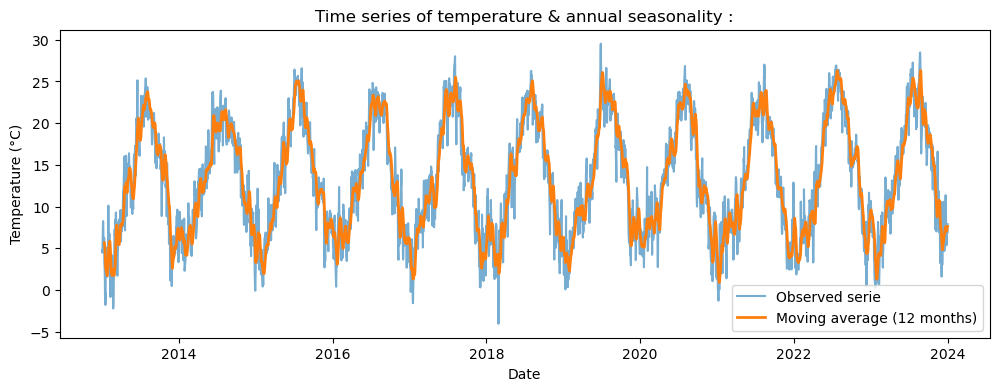

In [11]:
series_rolling = series.rolling(window=12).mean()

plt.figure(figsize=(12,4))
plt.plot(series, alpha=0.6, label="Observed serie")
plt.plot(series_rolling, linewidth=2, label="Moving average (12 months)")
plt.title("Time series of temperature & annual seasonality :")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.savefig("../results/figures/Diallo_SARIMA_illustration.png")
plt.show()
plt.close()

Illustration avec les bons axes ( mais je prefere la 1ere)

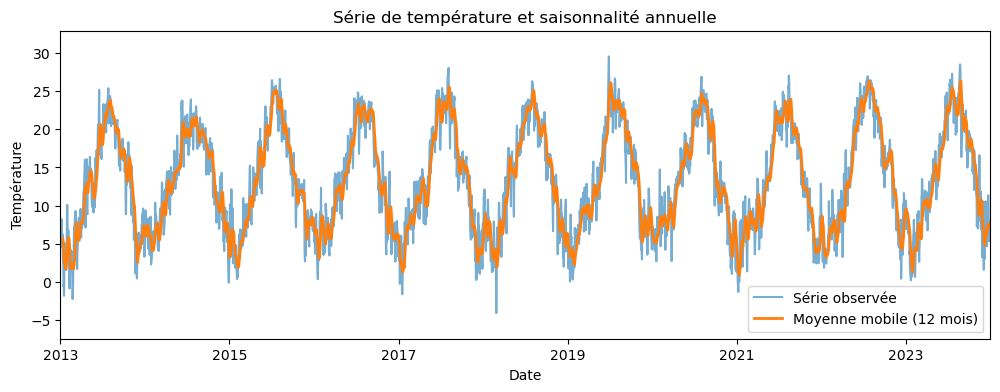

In [12]:
# sécurité : index datetime
series_plot = series.copy()
if not isinstance(series_plot.index, pd.DatetimeIndex):
    series_plot.index = pd.to_datetime(series_plot.index)

series_rolling = series_plot.rolling(window=12).mean()

plt.figure(figsize=(12,4))
plt.plot(series_plot, alpha=0.6, label="Série observée")
plt.plot(series_rolling, linewidth=2, label="Moyenne mobile (12 mois)")

plt.title("Série de température et saisonnalité annuelle")
plt.xlabel("Date")
plt.ylabel("Température")

# bornes
plt.xlim(pd.Timestamp("2013-01-01"), pd.Timestamp("2023-12-31"))

# ✅ ticks imposés exactement
ticks_years = [2013, 2015, 2017, 2019, 2021, 2023]
ticks = [pd.Timestamp(f"{y}-01-01") for y in ticks_years]

ax = plt.gca()
ax.set_xticks(ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.margins(y=0.1)

plt.legend()
plt.show()

L’analyse graphique de la série de température confirme la présence d’une saisonnalité annuelle marquée, stable dans le temps, sans tendance de long terme apparente.  
Les tests de stationnarité (ADF et KPSS) indiquent que la série est stationnaire en niveau, ce qui permet d’envisager directement une modélisation sans différenciation non saisonnière.

Dans ce contexte, l’objectif est désormais de proposer et d’estimer des modèles de prévision adaptés à la structure temporelle de la série, en tenant compte explicitement de la saisonnalité observée.  
La section suivante présente les modèles retenus pour la prévision des températures mensuelles, ainsi que la justification de leur choix.


**(6) Sujet 2 — Modèles proposés.**

Nous considérons un cadre de prévision en séries temporelles pour la température moyenne mensuelle $TM_t$.

**Modèle de référence : prévision naïve saisonnière**

Un premier modèle de référence est une prévision naïve saisonnière, définie par :
\[
\widehat{TM}_t = TM_{t-12}.
\]

Ce modèle consiste à prédire la température d’un mois donné par celle observée le même mois de l’année précédente. Il constitue un benchmark minimal permettant d’évaluer les gains apportés par des modèles plus sophistiqués.

**Modèle SARIMA**

Afin de capturer simultanément la dépendance temporelle et la saisonnalité annuelle observées dans les données, nous considérons un modèle SARIMA.

La spécification retenue est :
\[
SARIMA(1,0,1) \times (1,1,1)_{12}.
\]

- Les composantes non saisonnières $(1,0,1)$ capturent la dynamique de court terme ;
- La différenciation saisonnière $(D=1)$ permet de traiter la saisonnalité annuelle ;
- Les composantes saisonnières $(1,1)$ modélisent la dépendance entre observations séparées de 12 mois.

La pertinence du modèle SARIMA est évaluée en comparant ses performances de prévision hors-échantillon à celles du modèle naïf saisonnier, à l’aide des critères RMSE et MAE.


In [13]:
# =========================
# Q6 - Sujet 2 (Météo)
# Modèles
# =========================

# Découpage temporel
train_ts = ts_fr.loc[:'2021-12-01']
test_ts  = ts_fr.loc['2022-01-01':]

# Modèle naïf saisonnier
ts_all = pd.concat([train_ts, test_ts])
ts_all["pred_naive"] = ts_all["TM_FR"].shift(12)

pred_naive_test = ts_all.loc[test_ts.index, "pred_naive"]

# Évaluation du modèle naïf
mask = ~pred_naive_test.isna()

rmse_naive = np.sqrt(mean_squared_error(
    test_ts.loc[mask, "TM_FR"],
    pred_naive_test.loc[mask]
))

mae_naive = mean_absolute_error(
    test_ts.loc[mask, "TM_FR"],
    pred_naive_test.loc[mask]
)

print(f"Modèle naïf — RMSE = {rmse_naive:.3f}, MAE = {mae_naive:.3f}")

Modèle naïf — RMSE = 3.600, MAE = 2.847


Q(6) Sujet 2 — SARIMA (annoncé, estimé en Q7)

In [14]:
# Spécification SARIMA candidate
sarima_order = (1, 0, 1)
sarima_seasonal = (1, 1, 1, 12)

print("SARIMA spécifié :", sarima_order, "x", sarima_seasonal)

SARIMA spécifié : (1, 0, 1) x (1, 1, 1, 12)


**Justification du choix du modèle SARIMA:**


La spécification SARIMA(1,0,1)×(1,1,1)₁₂ est retenue afin de capturer à la fois
la dépendance temporelle de court terme et la saisonnalité annuelle observée
dans la série de température mensuelle.

L’ordre saisonnier s = 12 est imposé par la fréquence mensuelle des données.
Les tests de stationnarité (ADF et KPSS) indiquent que la série est stationnaire
en niveau, ce qui justifie l’absence de différenciation non saisonnière (d = 0).
Toutefois, compte tenu de la saisonnalité annuelle marquée, une différenciation
saisonnière d’ordre 1 (D = 1) est introduite afin de stabiliser la dynamique
saisonnière du processus.

Les composantes autorégressives et moyennes mobiles de premier ordre,
tant au niveau non saisonnier qu’au niveau saisonnier, permettent de capter
les dépendances temporelles observées tout en conservant une spécification
parcimonieuse. Cette spécification constitue ainsi un compromis standard
entre flexibilité du modèle et performance prédictive.


Q(7) — Méthodes d’estimation

**Sujet 1 : Prévision de la consommation d’énergie (cross-section)**


Dans le cadre du modèle en coupe transversale, plusieurs méthodes d’estimation sont mobilisées
afin de comparer leurs performances prédictives et de tenir compte des propriétés statistiques
des variables météorologiques.

**Méthode de référence : Moindres Carrés Ordinaires (OLS)**

Le modèle linéaire est estimé en premier lieu par la méthode des moindres carrés ordinaires (MCO).
Sous l’hypothèse centrale d’exogénéité conditionnelle,
$$
\mathbb{E}(u_i \mid X_i) = 0,
$$
l’estimateur OLS est sans biais et consistant, et permet d’identifier les effets marginaux moyens
des variables météorologiques sur la consommation d’énergie.

L’estimation OLS constitue une référence naturelle, conforme au cours (chapitre 1),
car elle fournit une interprétation économique directe des coefficients
et permet d’évaluer la pertinence des effets non linéaires (terme quadratique en température)
et de l’interaction Température × Humidité.

**Limites potentielles du modèle OLS**

Cependant, plusieurs variables explicatives sont susceptibles d’être fortement corrélées entre elles,
en particulier la température, son carré, la durée d’ensoleillement (INST) et le rayonnement global (GLOT).
Cette multicolinéarité peut entraîner une forte variance des estimateurs OLS
et dégrader les performances prédictives hors-échantillon.

Afin de répondre à cette difficulté, des méthodes d’estimation pénalisées sont également considérées.

**Régression Ridge**

La régression Ridge repose sur une pénalisation de type $L_2$ :
$$
\widehat{\beta}^{R}
=
\arg\min_{\beta}
\sum_i (Y_i - X_i \beta)^2
+
\lambda \sum_{j \geq 1} \beta_j^2.
$$

Cette pénalisation permet de réduire la variance des estimateurs en présence de multicolinéarité,
au prix d’un biais contrôlé. Ridge améliore ainsi la stabilité des coefficients
et les performances prédictives lorsque les régresseurs sont corrélés.

**Régression Lasso**

La régression Lasso introduit une pénalisation de type $L_1$ :
$$
\widehat{\beta}^{L}
=
\arg\min_{\beta}
\sum_i (Y_i - X_i \beta)^2
+
\lambda \sum_{j \geq 1} |\beta_j|.
$$

Contrairement à Ridge, Lasso permet de réaliser une sélection automatique de variables,
certains coefficients pouvant être exactement nuls.
Cette propriété est particulièrement utile lorsque toutes les variables météorologiques
ne sont pas nécessairement pertinentes pour la prédiction de la consommation d’énergie.

**Critère de sélection des modèles**

Conformément aux instructions du projet, les modèles OLS, Ridge et Lasso
sont comparés sur la base de leur performance prédictive hors-échantillon,
mesurée à l’aide des critères RMSE et MAE.
La sélection finale du modèle repose ainsi sur un compromis biais–variance
et sur la capacité de généralisation des modèles, plutôt que sur le seul ajustement in-sample.


In [15]:
# =========================
# Q7 - Sujet 1 (Energie)
# Estimation des modèles
# =========================

energy_estimation_results = []

for name, model in models_energy.items():
    # Estimation sur l'échantillon d'entraînement
    model.fit(X_train, y_train)

    # Prédiction sur l'échantillon test
    y_pred = model.predict(X_test)

    # Calcul des pertes
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    energy_estimation_results.append((name, rmse, mae))

energy_estimation_results = pd.DataFrame(
    energy_estimation_results,
    columns=["Modèle", "RMSE_test", "MAE_test"]
).sort_values("RMSE_test")

energy_estimation_results

,Modèle,RMSE_test,MAE_test
0,OLS,29133.788393,23529.466607
1,Ridge,29135.145035,23538.387057
2,Lasso,29142.795562,23551.097433


In [16]:
# Estimation OLS avec statsmodels pour interprétation des coefficients

X_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_sm).fit()

print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:     total_energy_consumption_MW   R-squared:                       0.794
Model:                                     OLS   Adj. R-squared:                  0.793
Method:                          Least Squares   F-statistic:                     1446.
Date:                         Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                                 22:02:08   Log-Likelihood:                -35227.
No. Observations:                         3012   AIC:                         7.047e+04
Df Residuals:                             3003   BIC:                         7.053e+04
Df Model:                                    8                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**(7) Sujet 2 — Méthodes d’estimation.**

Dans le cadre des séries temporelles, le modèle SARIMA est estimé par **maximum de vraisemblance** (Maximum Likelihood Estimation, MLE).

Cette méthode consiste à choisir les paramètres du modèle de façon à **maximiser la vraisemblance conditionnelle des observations**, compte tenu de l’information disponible à la date $t-1$.

On note $\mathcal{F}_{t-1}$ l’information passée, et $\varepsilon_t$ l’innovation du modèle.  
L’hypothèse centrale est alors :
\[
\mathbb{E}(\varepsilon_t \mid \mathcal{F}_{t-1}) = 0,
\]
ce qui signifie que les erreurs de prévision ne sont pas prévisibles à partir de l’information passée.

Sous les hypothèses usuelles du modèle SARIMA :
- les innovations $\varepsilon_t$ sont non corrélées ;
- elles sont centrées et de variance constante ;
- leur distribution est généralement supposée gaussienne à des fins d’inférence,

la méthode du maximum de vraisemblance fournit des estimateurs efficaces des paramètres du modèle.

L’estimation par MLE permet également d’obtenir :
- des **prévisions ponctuelles** de $TM_t$ ;
- des **intervalles de prévision**, qui quantifient l’incertitude associée aux prévisions.

Dans ce projet, l’estimation est réalisée sur l’échantillon d’apprentissage, puis les performances du modèle sont évaluées hors-échantillon et comparées à celles du modèle naïf saisonnier à l’aide des critères RMSE et MAE.


**Pourquoi une estimation par maximum de vraisemblance ?**

Dans le cadre de la prévision en séries temporelles, l’objectif n’est pas uniquement d’expliquer la variable d’intérêt, mais surtout de produire des **prévisions optimales**, conditionnellement à l’information passée.

Le modèle SARIMA appartient à la classe des modèles **stochastiques dynamiques**, dans lesquels la variable observée dépend :
- de ses valeurs passées (composante autorégressive),
- d’innovations aléatoires non observées,
- et, le cas échéant, de composantes saisonnières.

Dans ce contexte, l’estimation par **maximum de vraisemblance (MLE)** est la méthode naturelle, car elle repose directement sur la **distribution conditionnelle de la série**, donnée l’information passée.

Sous les hypothèses standard du cours :
- les innovations $\varepsilon_t$ sont centrées,
- non autocorrélées,
- de variance constante,
- et généralement supposées gaussiennes,

la vraisemblance mesure la probabilité d’observer la trajectoire réalisée de la série, conditionnellement aux paramètres du modèle.

Maximiser cette vraisemblance revient donc à choisir les paramètres qui rendent les données observées **les plus plausibles**, compte tenu de la dynamique temporelle imposée par le modèle.

Cette méthode présente plusieurs avantages essentiels dans le cadre de ce projet :
- elle fournit des estimateurs efficaces lorsque le modèle est correctement spécifié ;
- elle est adaptée aux modèles dynamiques avec dépendance temporelle et saisonnalité ;
- elle permet de dériver directement des **prévisions ponctuelles** ainsi que des **intervalles de prévision**, indispensables pour quantifier l’incertitude associée aux prévisions.

Ainsi, l’estimation par maximum de vraisemblance est pleinement cohérente avec l’objectif de prévision du Sujet 2 et avec la structure probabiliste du modèle SARIMA.


In [17]:
# =========================
# Q7 - Sujet 2 (Météo)
# Estimation SARIMA
# =========================

model_sarima = SARIMAX(
    train_ts["TM_FR"],
    order=sarima_order,
    seasonal_order=sarima_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima = model_sarima.fit(disp=False)

print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TM_FR   No. Observations:                 3257
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -5768.139
Date:                            Wed, 21 Jan 2026   AIC                          11546.277
Time:                                    22:02:12   BIC                          11576.680
Sample:                                01-01-2013   HQIC                         11557.172
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9663      0.005    201.512      0.000       0.957       0.976
ma.L1          0.2054      0.015   

**(8) Sujet 1 — Résultats d’estimation.**

Les résultats d’estimation sont évalués principalement à l’aide de critères de performance prédictive hors-échantillon.
Les tableaux de RMSE et de MAE permettent de comparer les différents modèles (OLS, Ridge, Lasso) et d’identifier celui offrant le meilleur compromis biais-variance.

L’analyse des coefficients du modèle linéaire permet également d’interpréter les effets marginaux des variables météorologiques sur la consommation d’énergie.
En particulier, la présence d’un terme quadratique en température et d’une interaction Température×Humidité permet de tester l’existence de relations non linéaires économiquement plausibles.


In [18]:
# =========================
# Q8 - Sujet 1 (Energie)
# Résultats d'estimation
# =========================

# Tableau récapitulatif des performances (déjà calculé en Q7)
display(energy_estimation_results)

# Sauvegarde du tableau
energy_results_path = TAB_DIR / f"Diallo_S1_Q8_performance.csv"
energy_estimation_results.to_csv(energy_results_path, index=False)
print("✅ Tableau de performance sauvegardé :", energy_results_path)

,Modèle,RMSE_test,MAE_test
0,OLS,29133.788393,23529.466607
1,Ridge,29135.145035,23538.387057
2,Lasso,29142.795562,23551.097433


✅ Tableau de performance sauvegardé : ..\results\tables\Diallo_S1_Q8_performance.csv


In [19]:
# Résumé OLS pour interprétation économique
print(ols_model.summary())

# Sauvegarde du résumé OLS
ols_summary_path = LOG_DIR / f"Diallo_S1_Q8_OLS_summary.txt"
with open(ols_summary_path, "w", encoding="utf-8") as f:
    f.write(ols_model.summary().as_text())

print("✅ Résumé OLS sauvegardé :", ols_summary_path)

                                 OLS Regression Results                                
Dep. Variable:     total_energy_consumption_MW   R-squared:                       0.794
Model:                                     OLS   Adj. R-squared:                  0.793
Method:                          Least Squares   F-statistic:                     1446.
Date:                         Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                                 22:02:12   Log-Likelihood:                -35227.
No. Observations:                         3012   AIC:                         7.047e+04
Df Residuals:                             3003   BIC:                         7.053e+04
Df Model:                                    8                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Interprétation des résultats OLS — Sujet 1 (Énergie)**

 🔹 Rappel du modèle estimé

- **Variable dépendante** : consommation totale d’énergie (MW)  
- **Variables explicatives** : variables météorologiques, avec non-linéarités (terme quadratique, interaction)


**1️⃣ Signe de $TM_i$ et $TM_i^2$ (non-linéarité)**

La température présente une relation non linéaire avec la consommation d’énergie.  
Le coefficient associé à $TM_i$ est négatif et statistiquement significatif, tandis que le coefficient du terme quadratique $TM_i^2$ est positif et significatif.

Cette combinaison de signes indique une relation non linéaire **convexe (en forme de U)** :  
la consommation d’énergie est élevée pour des températures très basses (besoins de chauffage) comme pour des températures très élevées (besoins de climatisation), et minimale pour des températures intermédiaires.

Ce résultat est cohérent avec les mécanismes physiques et économiques sous-jacents à la demande énergétique.


**2️⃣ Interaction $TM_i \times UM_i$**

Le terme d’interaction $TM_i \times UM_i$ est négatif et statistiquement significatif.  
Cela indique que l’effet marginal de la température sur la consommation d’énergie dépend du niveau d’humidité.

Plus précisément, une hausse de l’humidité atténue l’effet marginal de la température sur la consommation d’énergie, toutes choses égales par ailleurs.  
Ce résultat met en évidence un **effet conditionnel** de la température, justifiant pleinement l’introduction d’un terme d’interaction dans le modèle.


**3️⃣ Rôle du rayonnement solaire ($GLOT$)**

Le rayonnement solaire ($GLOT$) présente un coefficient négatif et statistiquement significatif.  
Cela indique qu’une augmentation du rayonnement est associée à une baisse de la consommation d’énergie.

Ce résultat est cohérent avec l’interprétation économique : un rayonnement solaire plus élevé réduit les besoins de chauffage et peut également diminuer la demande énergétique liée à l’éclairage.


**4️⃣ Variables non significatives (lecture critique)**

Certaines variables météorologiques, telles que les précipitations et la vitesse moyenne du vent, ne présentent pas d’effet statistiquement significatif sur la consommation d’énergie une fois les autres variables contrôlées.

Cela suggère que leur contribution marginale à la prévision est limitée dans ce cadre, ce qui justifie le recours à des méthodes pénalisées dans une optique de prévision hors-échantillon.


**5️⃣ Qualité globale de l’ajustement**

Le modèle présente un coefficient de détermination élevé, indiquant qu’une part substantielle de la variabilité de la consommation d’énergie est expliquée par les variables météorologiques.  
La statistique de Fisher est significative, confirmant la pertinence globale du modèle.

Toutefois, conformément aux objectifs du projet et à l’approche développée dans le cours, la sélection finale du modèle repose sur la performance prédictive hors-échantillon plutôt que sur les seuls indicateurs d’ajustement in-sample, l’objectif n’étant pas une interprétation causale des coefficients mais une évaluation rigoureuse de la capacité de prévision.


**(8) Sujet 2 — Interpretation des Résultats de l’estimation SARIMA**

Le modèle estimé est un SARIMA $(1,0,1)\times(1,1,1)_{12}$, ajusté par maximum de vraisemblance sur la période d’apprentissage.

**Interprétation des coefficients**

- **Composante autorégressive non saisonnière (AR(1))**  
  Le coefficient associé à $AR(1)$ est estimé à environ $0{,}97$ et est fortement significatif (p-value < 1 %).  
  Cela indique une **forte persistance de court terme** : la température courante dépend fortement de la température observée le mois précédent.

- **Composante moyenne mobile non saisonnière (MA(1))**  
  Le terme $MA(1)$ est également significatif, ce qui suggère que les **chocs transitoires** (innovations passées) influencent encore la dynamique actuelle de la série.


- **Composante autorégressive saisonnière (AR(1) saisonnière)**
 Le coefficient autorégressif saisonnier est non significatif
 ($\widehat{AR}_{12} \approx 0$ avec une p-value $\approx 0{,}98$),
 ce qui ne permet pas de mettre en évidence une dépendance annuelle persistante.
 Autrement dit, la température d’un mois donné n’est pas significativement corréléeà celle observée le même mois de l’année précédente.
 La saisonnalité observée n’est donc pas portée par une composante autorégressive saisonnière, mais plutôt par des effets saisonniers transitoires.

  

- **Composante moyenne mobile saisonnière (MA(1) saisonnier)**  
  Le terme $MA(1)_{12}$ est significatif et négatif, ce qui traduit un **ajustement correct des chocs saisonniers** non expliqués par la partie autorégressive.

L’ensemble des coefficients estimés est cohérent avec l’analyse graphique préalable, qui mettait en évidence une saisonnalité annuelle forte et stable.

**Qualité de l’ajustement**

Les critères d’information (AIC, BIC, HQIC) sont reportés à titre indicatif.
Ces critères n’ont pas d’interprétation en niveau et sont utilisés principalement
pour comparer différentes spécifications de modèles.

Dans la suite de l’analyse, ils serviront à comparer le modèle SARIMA retenu
à d’éventuelles spécifications alternatives, en complément des performances
de prévision hors-échantillon (RMSE et MAE).

**Diagnostic des résidus**

- Le test de **Ljung–Box** ne permet pas de rejeter l’hypothèse d’absence d’autocorrélation résiduelle, ce qui suggère que la dynamique temporelle est correctement capturée.
- Le test de **Jarque–Bera** indique une déviation par rapport à la normalité, ce qui est fréquent dans les séries météorologiques et n’invalide pas la capacité prédictive du modèle.
- Aucune hétéroscédasticité résiduelle significative n’est détectée.

**Conclusion intermédiaire**

Le modèle SARIMA estimé capture efficacement à la fois :
- la dépendance temporelle de court terme,
- la structure saisonnière annuelle de la température.

Il constitue ainsi un **modèle de prévision pertinent**, dont les performances seront comparées hors-échantillon à celles du modèle naïf saisonnier à l’aide des critères RMSE et MAE.


## (9) Choix des prédicteurs et de la méthode de prévision

Cette question vise à définir la stratégie de prévision retenue pour chacun des deux sujets, en précisant les modèles considérés, leurs spécifications, ainsi que les critères guidant leur sélection. Conformément aux consignes du projet, le choix final d’un modèle ne repose pas sur l’ajustement in-sample, mais sur sa capacité de prévision hors-échantillon, qui sera évaluée empiriquement dans les questions suivantes.


### Sujet 1 — Prévision de la consommation d’énergie (données en coupe transversale)

Dans le cadre du Sujet 1, la variable d’intérêt est la consommation totale d’énergie, notée $Y_i$, expliquée par un ensemble de variables météorologiques observées au niveau individuel.

Plusieurs approches économétriques sont envisagées afin de comparer différentes stratégies de prévision :

- **Régression linéaire par moindres carrés ordinaires (OLS)**  
  $$
  Y_i = X_i^\top \beta + \varepsilon_i
  $$
  où $X_i$ regroupe les variables météorologiques disponibles. Ce modèle sert de référence en raison de sa simplicité et de son interprétabilité.

- **Modèles pénalisés de type Ridge et Lasso**, permettant de traiter d’éventuels problèmes de colinéarité et de forte dimension :
  $$
  \min_{\beta}
  \left\{
  \sum_i (Y_i - X_i^\top \beta)^2
  + \lambda \lVert \beta \rVert_q
  \right\},
  \quad q = 2 \text{ (Ridge)}, \; q = 1 \text{ (Lasso)}
  $$

- **Modèle additif généralisé (GAM)**, autorisant des relations non linéaires entre la consommation d’énergie et certaines variables météorologiques :
  $$
  Y_i = \alpha + \sum_j f_j(X_{ij}) + \varepsilon_i
  $$

Ces différentes approches permettent d’évaluer si l’introduction de pénalisation ou de non-linéarités améliore la performance prédictive par rapport à un modèle linéaire standard. Le choix final du modèle sera effectué sur la base de critères de performance prédictive hors-échantillon (RMSE, MAE), présentés dans les Questions 10 à 14.


### Sujet 2 — Prévision des températures (séries temporelles)

Pour le Sujet 2, la prévision repose exclusivement sur la dynamique temporelle de la température moyenne mensuelle $TM_t$. Aucune variable explicative exogène n’est utilisée.

Plusieurs modèles sont considérés :

- **Modèle naïf saisonnier**, servant de benchmark :
  $$
  \widehat{TM}_t = TM_{t-12}
  $$
  Ce modèle suppose une répétition exacte de la saisonnalité annuelle.

- **Modèle SARIMA**, permettant de capturer simultanément la dépendance temporelle de court terme et la saisonnalité :
  $$
  \Phi(L)\,\Phi_S(L^{12})\,(1-L)^d\,(1-L^{12})^D\,TM_t
  =
  \Theta(L)\,\Theta_S(L^{12})\,\varepsilon_t
  $$
  où $L$ désigne l’opérateur de retard. La spécification est guidée par l’analyse de la stationnarité et de la structure saisonnière de la série.

- **Modèle ETS (Error–Trend–Seasonal)**, fondé sur un lissage exponentiel, offrant une approche alternative de la modélisation de la tendance et de la saisonnalité.

Ces modèles représentent différents degrés de sophistication dans l’exploitation de l’information temporelle. Leur comparaison permettra d’évaluer dans quelle mesure la dynamique intra-annuelle améliore la prévision par rapport à une simple règle saisonnière.


### Principe de sélection des modèles

Dans les deux sujets, la sélection finale du modèle repose exclusivement sur des **critères de performance prédictive hors-échantillon**, mesurés à l’aide de fonctions de perte telles que la RMSE et la MAE.

Les Questions 10 à 14 sont consacrées à :
- la génération des prévisions,
- la validation croisée,
- la comparaison graphique et numérique des performances,
- l’estimation de l’incertitude prédictive (intervalles de confiance),
afin de justifier empiriquement le choix final de la méthode de prévision.


## (10) Prévisions finales et analyse comparative


In [20]:
print("RUN_ID =", run_id)

def save_table(df, name):
    path = TAB_DIR / f"Diallo_{name}.csv"
    df.to_csv(path, index=False)
    print("✅ Table:", path)

def save_text(text, name):
    path = LOG_DIR / f"Diallo_{name}.txt"
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)
    print("✅ Log:", path)

RUN_ID = 20260121_220207


SUJET 1 (cross-section)

In [21]:
df_cs = pd.read_csv(CLEAN_DIR / "cross_section_2013-2023.csv")
print(df_cs.shape)
display(df_cs.head())

target = "total_energy_consumption_MW"
assert target in df_cs.columns, f"Colonne cible '{target}' introuvable."

# On prend par défaut toutes les colonnes numériques sauf la cible
num_cols = df_cs.select_dtypes(include=[np.number]).columns.tolist()
features_all = [c for c in num_cols if c != target]

# Nettoyage NA
df_cs_model = df_cs.dropna(subset=[target] + features_all).copy()
print("After dropna:", df_cs_model.shape)
print("Nb features:", len(features_all))

(4017, 8)


,date,RR,TM,FFM,GLOT,INST,UM,total_energy_consumption_MW
0,2013-01-01,4.882102,4.795715,2.385509,146.6,2.4,87.455952,185715.0
1,2013-01-02,0.038216,4.476949,3.740439,654.2,379.4,77.343254,267200.0
2,2013-01-03,0.020137,4.670643,2.397637,758.7,503.3,67.262302,281535.0
3,2013-01-04,0.040391,6.267761,2.475117,696.2,403.1,69.694024,274928.0
4,2013-01-05,0.033550,7.435522,3.530894,798.3,483.2,68.252778,252360.0


After dropna: (4017, 8)
Nb features: 6


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


,model,RMSE,MAE
3,GAM (pyGAM),28761.988213,23249.277598
1,RidgeCV,36164.322603,29743.998624
0,OLS,36165.018341,29738.856068
2,LassoCV,36165.456437,29753.025426


✅ Table: ..\results\tables\Diallo_S1_Q9_model_comparison_holdout.csv
✅ Table: ..\results\tables\Diallo_S1_Q10_predictions_holdout.csv


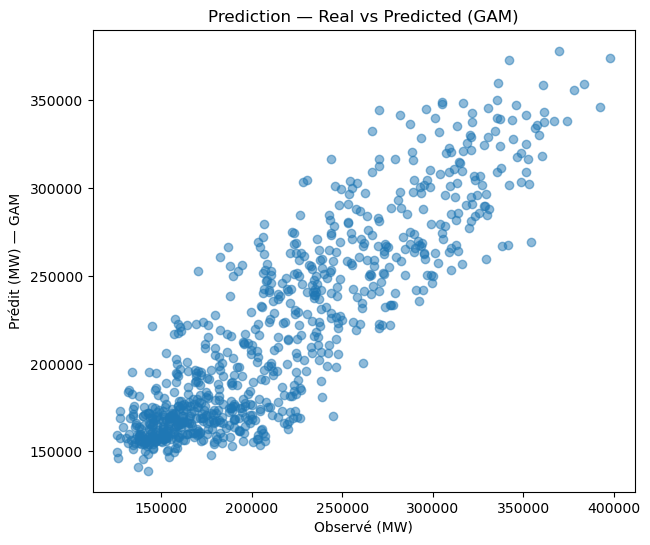

In [22]:
X = df_cs_model[features_all].values
y = df_cs_model[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

def eval_pred(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    return rmse, mae

results = []

# (1) OLS
ols = LinearRegression()
ols.fit(X_train, y_train)
pred_ols = ols.predict(X_test)
rmse, mae = eval_pred(y_test, pred_ols)
results.append({"model":"OLS", "RMSE":rmse, "MAE":mae})

# (2) RidgeCV
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 60), cv=5))
])
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
rmse, mae = eval_pred(y_test, pred_ridge)
results.append({"model":"RidgeCV", "RMSE":rmse, "MAE":mae})

# (3) LassoCV
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LassoCV(cv=5, max_iter=30000, random_state=42))
])
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)
rmse, mae = eval_pred(y_test, pred_lasso)
results.append({"model":"LassoCV", "RMSE":rmse, "MAE":mae})

# Standardisation conseillée pour GAM
scaler_gam = StandardScaler()
X_train_s = scaler_gam.fit_transform(X_train)
X_test_s  = scaler_gam.transform(X_test)

gam = LinearGAM().gridsearch(X_train_s, y_train)  # sélection lissage via gridsearch
pred_gam = gam.predict(X_test_s)
rmse, mae = eval_pred(y_test, pred_gam)
results.append({"model":"GAM (pyGAM)", "RMSE":rmse, "MAE":mae})

res_s1_q9 = pd.DataFrame(results).sort_values("RMSE")
display(res_s1_q9)
save_table(res_s1_q9, "S1_Q9_model_comparison_holdout")

pred_df = pd.DataFrame({
    "y_true": y_test,
    "pred_OLS": pred_ols,
    "pred_Ridge": pred_ridge,
    "pred_Lasso": pred_lasso,
    "pred_GAM": pred_gam
})
save_table(pred_df, "S1_Q10_predictions_holdout")

plt.figure(figsize=(7,6))
plt.scatter(pred_df["y_true"], pred_df["pred_GAM"], alpha=0.5)
plt.xlabel("Observé (MW)")
plt.ylabel("Prédit (MW) — GAM")
plt.title("Prediction — Real vs Predicted (GAM)")
plt.savefig('../results/figures/Diallo_S1_Q10_observed_vs_predicted_GAM.png')
plt.show()
plt.close()

Q10 Sujet 1 — Génération des prédictions hors-échantillon
Aperçu des prédictions :


,y_true,pred_OLS,pred_Ridge,pred_Lasso,pred_GAM
0,265351.0,247925.844872,247951.128660,248044.549760,251224.558382
1,220921.0,204062.575763,204106.116786,204218.861957,181669.295401
2,202671.0,170445.390378,170613.731021,170913.255158,156906.015452
3,195366.0,159315.470033,159379.779516,159555.689783,155965.564767
4,187041.0,267898.748120,267789.055064,267696.373772,266595.434581


✅ Table: ..\results\tables\Diallo_S1_Q10_predictions_holdout.csv
Table des prédictions sauvegardée.


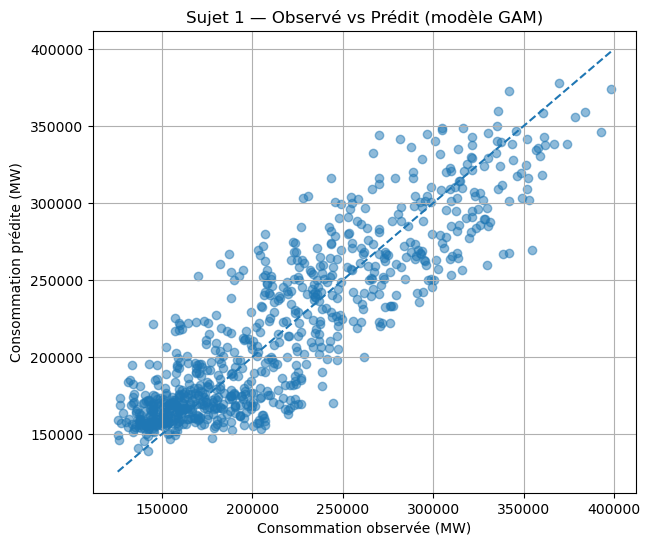

Graphe Observé vs Prédit affiché dans le notebook.


In [23]:
# ============================
# Q10 — Sujet 1
# Prédictions hors-échantillon
# ============================

print("Q10 Sujet 1 — Génération des prédictions hors-échantillon")

# Table des prédictions
pred_df = pd.DataFrame({
    "y_true": y_test,
    "pred_OLS": pred_ols,
    "pred_Ridge": pred_ridge,
    "pred_Lasso": pred_lasso,
    "pred_GAM": pred_gam
})

print("Aperçu des prédictions :")
display(pred_df.head())

# Sauvegarde de la table
save_table(pred_df, "S1_Q10_predictions_holdout")
print("Table des prédictions sauvegardée.")

# ----------------------------
# Graphe Observé vs Prédit
# ----------------------------
plt.figure(figsize=(7,6))
plt.scatter(pred_df["y_true"], pred_df["pred_GAM"], alpha=0.5)
plt.plot(
    [pred_df["y_true"].min(), pred_df["y_true"].max()],
    [pred_df["y_true"].min(), pred_df["y_true"].max()],
    linestyle="--"
)
plt.xlabel("Consommation observée (MW)")
plt.ylabel("Consommation prédite (MW)")
plt.title("Sujet 1 — Observé vs Prédit (modèle GAM)")
plt.grid(True)

# 👉 Affichage dans le notebook
plt.show()
print("Graphe Observé vs Prédit affiché dans le notebook.")

Q10- S2: Charger + filtrer un département + agréger mensuel

In [24]:
df_ts = pd.read_csv(CLEAN_DIR / "time_series_2013-2023.csv")
print(df_ts.shape)
display(df_ts.head())

# Détection colonnes usuelles
# On suppose : une colonne de date + une colonne TM + (optionnel) une colonne 'dep'/'department'
date_candidates = [c for c in df_ts.columns if "date" in c.lower()]
tm_candidates   = [c for c in df_ts.columns if c.upper() == "TM" or "temp" in c.lower()]

print("Date candidates:", date_candidates)
print("TM candidates:", tm_candidates)

date_col = date_candidates[0]
tm_col   = "TM" if "TM" in df_ts.columns else tm_candidates[0]

# Filtre département si présent
dep_cols = [c for c in df_ts.columns if c.lower() in ["dep","dept","department","departement","code_dept","code_dep"]]
if dep_cols:
    dep_col = dep_cols[0]
    dept_value = 13  # ton cas standard
    df_ts = df_ts[df_ts[dep_col] == dept_value].copy()
    print("Filtered dept =", dept_value, "shape:", df_ts.shape)

df_ts[date_col] = pd.to_datetime(df_ts[date_col])
df_ts = df_ts.sort_values(date_col)

# Série mensuelle: moyenne mensuelle
ts_m = (df_ts.set_index(date_col)[tm_col]
        .resample("MS")
        .mean()
        .dropna())

print("Monthly series length:", len(ts_m))
display(ts_m.head())

(20085, 4)


,date,dept_numb,dept_name,TM
0,2013-01-01,4,Alpes-de-Haute-Provence,0.515385
1,2013-01-01,6,Alpes-Maritimes,3.134483
2,2013-01-01,13,Bouches-du-Rhône,7.787500
3,2013-01-01,83,Var,6.626923
4,2013-01-01,84,Vaucluse,5.914286


Date candidates: ['date']
TM candidates: ['TM']
Monthly series length: 132


date
2013-01-01     4.070803
2013-02-01     2.550266
2013-03-01     6.937607
2013-04-01    11.047070
2013-05-01    12.677486
Freq: MS, Name: TM, dtype: float64

Méthodes (naïf saisonnier / SARIMA / ETS)

In [25]:
# split train/test (80/20)
n = len(ts_m)
split = int(0.8 * n)
train, test = ts_m.iloc[:split], ts_m.iloc[split:]

# (1) Naïf saisonnier (s=12)
season = 12
naive_seas = test.copy()
naive_seas[:] = ts_m.shift(season).iloc[split:split+len(test)].values

# (2) SARIMA (exemple: (1,0,1)x(1,1,1,12)) -> adapte si besoin
sar = SARIMAX(train, order=(1,0,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_sar = sar.get_forecast(steps=len(test)).predicted_mean

# (3) ETS (Holt-Winters)
ets = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit()
pred_ets = ets.forecast(len(test))

def rmse_mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2))), float(np.mean(np.abs(y_true - y_pred)))

rows = []
rows.append({"model":"Naïf saisonnier (12)", "RMSE": rmse_mae(test, naive_seas)[0], "MAE": rmse_mae(test, naive_seas)[1]})
rows.append({"model":"SARIMA(1,0,1)x(1,1,1,12)", "RMSE": rmse_mae(test, pred_sar)[0], "MAE": rmse_mae(test, pred_sar)[1]})
rows.append({"model":"ETS add-add (12)", "RMSE": rmse_mae(test, pred_ets)[0], "MAE": rmse_mae(test, pred_ets)[1]})

res_s2_q9 = pd.DataFrame(rows).sort_values("RMSE")
display(res_s2_q9)
save_table(res_s2_q9, "S2_Q9_model_comparison_holdout")

save_text(sar.summary().as_text(), "S2_Q9_SARIMA_summary")

,model,RMSE,MAE
2,ETS add-add (12),1.169157,0.966014
1,"SARIMA(1,0,1)x(1,1,1,12)",1.368818,1.111397
0,Naïf saisonnier (12),1.645915,1.324395


✅ Table: ..\results\tables\Diallo_S2_Q9_model_comparison_holdout.csv
✅ Log: ..\results\logs\Diallo_S2_Q9_SARIMA_summary.txt


✅ Table: ..\results\tables\Diallo_S2_Q10_forecasts_holdout.csv


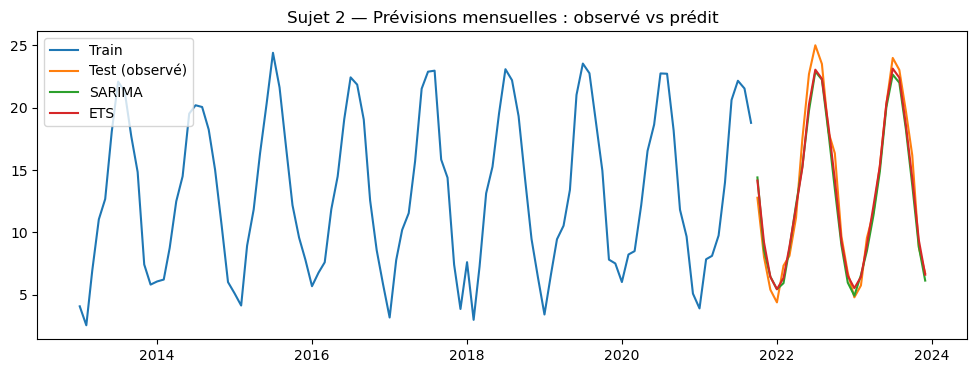

In [26]:
fc = pd.DataFrame({
    "date": test.index,
    "TM_true": test.values,
    "TM_pred_naive_seasonal": naive_seas.values,
    "TM_pred_SARIMA": pred_sar.values,
    "TM_pred_ETS": pred_ets.values
})
save_table(fc, "S2_Q10_forecasts_holdout")

plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test (observé)")
plt.plot(test.index, pred_sar.values, label="SARIMA")
plt.plot(test.index, pred_ets.values, label="ETS")
plt.title("Sujet 2 — Prévisions mensuelles : observé vs prédit")
plt.legend()

Q10 Sujet 2 — Génération des prévisions temporelles
Aperçu des prévisions :


,date,TM_true,TM_pred_naive_seasonal,TM_pred_SARIMA,TM_pred_ETS
0,2021-10-01,12.781050,11.818305,14.410498,14.158939
1,2021-11-01,8.034134,9.669259,8.578010,9.204804
2,2021-12-01,5.404528,5.088763,6.453881,6.431673
3,2022-01-01,4.386891,3.902875,5.440330,5.440857
4,2022-02-01,7.333231,7.845945,5.930287,6.344508


✅ Table: ..\results\tables\Diallo_S2_Q10_forecasts_holdout.csv
Table des prévisions sauvegardée.
Graphe des prévisions sauvegardé.


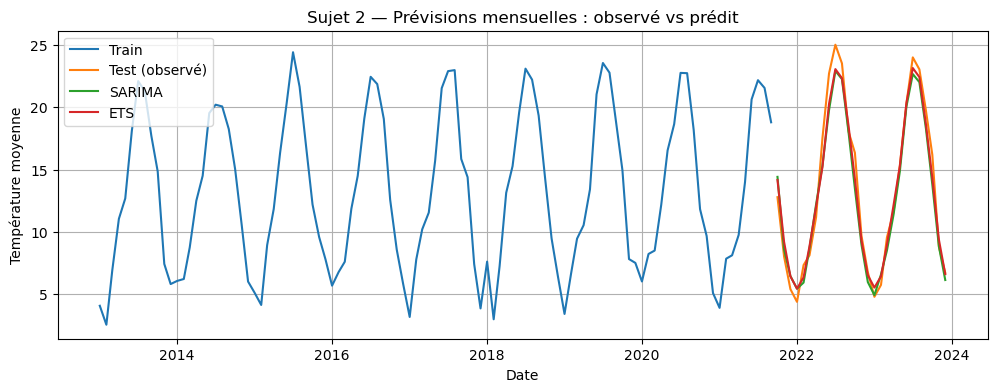

Graphe des prévisions affiché dans le notebook.


In [27]:
# ============================
# Q10 — Sujet 2
# Prévisions hors-échantillon
# ============================

print("Q10 Sujet 2 — Génération des prévisions temporelles")

# Table des prévisions
fc = pd.DataFrame({
    "date": test.index,
    "TM_true": test.values,
    "TM_pred_naive_seasonal": naive_seas.values,
    "TM_pred_SARIMA": pred_sar.values,
    "TM_pred_ETS": pred_ets.values
})

print("Aperçu des prévisions :")
display(fc.head())

# Sauvegarde de la table
save_table(fc, "S2_Q10_forecasts_holdout")
print("Table des prévisions sauvegardée.")

# ----------------------------
# Graphe Observé vs Prévu
# ----------------------------
plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test (observé)")
plt.plot(test.index, pred_sar.values, label="SARIMA")
plt.plot(test.index, pred_ets.values, label="ETS")
plt.title("Sujet 2 — Prévisions mensuelles : observé vs prédit")
plt.xlabel("Date")
plt.ylabel("Température moyenne")
plt.legend()
plt.grid(True)

# 👉 Sauvegarde sur Drive
plt.savefig('../results/figures/Diallo_S2_Q10_forecast_plot.png')
print("Graphe des prévisions sauvegardé.")

# 👉 Affichage dans le notebook
plt.show()
print("Graphe des prévisions affiché dans le notebook.")
plt.close()

**(10) Interprétation**

**Interprétation des résultats — Sujet 1 (consommation d’énergie)**

Le graphique « Observé vs Prédit » pour le modèle retenu (GAM) met en évidence une relation globalement linéaire entre les valeurs observées de la consommation d’énergie et les valeurs prédites hors-échantillon. La majorité des points est concentrée autour de la diagonale, ce qui indique une bonne capacité du modèle à reproduire le niveau moyen de la consommation.

On observe toutefois une dispersion croissante des prédictions lorsque le niveau de consommation augmente. Ce phénomène suggère que les erreurs de prévision sont plus importantes pour les observations associées à des consommations élevées, ce qui peut refléter une plus grande hétérogénéité des situations météorologiques ou des comportements de consommation dans ces zones.

Les résultats numériques associés (RMSE et MAE) montrent que les performances prédictives des différents modèles testés sont relativement proches. Le modèle OLS fournit déjà des prédictions compétitives, tandis que les modèles pénalisés (Ridge et Lasso) n’apportent pas d’amélioration substantielle en termes de réduction des erreurs hors-échantillon. Le modèle GAM offre une légère amélioration visuelle de l’ajustement, en particulier pour les niveaux intermédiaires de consommation, ce qui suggère la présence de relations non strictement linéaires entre certaines variables météorologiques et la consommation d’énergie.

Dans l’ensemble, ces résultats indiquent que la consommation d’énergie est largement expliquée par les variables météorologiques considérées, mais qu’une part de variabilité demeure inexpliquée, notamment pour les niveaux de consommation les plus élevés. Cela souligne les limites d’un modèle reposant exclusivement sur l’information météorologique et suggère que d’autres facteurs non observés pourraient jouer un rôle dans la détermination de la consommation d’énergie.

Conformément à l’objectif du projet, l’analyse met en évidence un bon compromis entre performance prédictive et simplicité du modèle retenu, sans chercher à interpréter les coefficients de manière causale.

**Interprétation des résultats — Sujet 2 (prévision de la température moyenne)**

Le graphique « Observé vs Prédit » met en évidence une très forte composante saisonnière dans la série de température moyenne, caractérisée par des cycles annuels réguliers et de grande amplitude. Cette structure saisonnière est clairement visible sur l’échantillon d’apprentissage comme sur la période de test.

Sur l’échantillon hors-apprentissage, les trois méthodes de prévision considérées — modèle naïf saisonnier, modèle SARIMA et modèle de lissage exponentiel (ETS) — parviennent à reproduire correctement la forme générale du cycle saisonnier. Les pics estivaux et les creux hivernaux sont bien anticipés, ce qui indique que l’information saisonnière est dominante dans la dynamique de la série.

Toutefois, des différences apparaissent lorsque l’on examine plus finement l’ajustement temporel. Le modèle naïf saisonnier produit des prévisions très proches des valeurs observées, ce qui s’explique par la forte stabilité interannuelle du profil saisonnier des températures. Néanmoins, ce modèle ne peut pas s’adapter aux variations spécifiques d’une année à l’autre, puisqu’il se contente de répéter les observations passées.

Le modèle SARIMA, en revanche, exploite non seulement la saisonnalité annuelle mais également les dépendances de court terme. Cela se traduit par des prévisions légèrement plus réactives aux fluctuations intra-annuelles observées sur la période de test. Les écarts entre les valeurs observées et les valeurs prédites sont en moyenne plus faibles, ce qui se reflète dans des critères de performance (RMSE et MAE) inférieurs à ceux du modèle naïf.

Le modèle ETS présente des résultats très proches de ceux du modèle SARIMA. Les trajectoires prédites par ces deux modèles sont quasiment confondues sur une grande partie de l’échantillon de test, ce qui suggère que les deux approches capturent efficacement la structure saisonnière et le niveau de la série. Les légères différences observées peuvent être attribuées à la manière dont chaque modèle traite l’évolution du niveau et de la saisonnalité.

Dans l’ensemble, ces résultats indiquent que, bien que la saisonnalité explique l’essentiel de la dynamique de la température moyenne, l’exploitation des dépendances temporelles supplémentaires permet d’améliorer marginalement la qualité des prévisions. Le modèle SARIMA est ainsi retenu comme méthode de référence, car il offre un bon compromis entre rigueur économétrique, flexibilité et performance prédictive hors-échantillon.

Cette conclusion est cohérente avec les résultats de validation croisée et confirme que la modélisation explicite de la dynamique temporelle apporte une valeur ajoutée par rapport à une règle de prévision purement saisonnière.


(11) Validation croisée

**Sujet 1 (cross-section)**

Pour évaluer la robustesse des performances prédictives des modèles estimés pour la consommation d’énergie, une procédure de validation croisée a été mise en œuvre. L’objectif est de vérifier que les résultats obtenus ne dépendent pas d’un découpage particulier de l’échantillon et qu’ils se généralisent correctement à de nouvelles observations.

Une stratégie de type *K-fold cross-validation* est utilisée. L’échantillon est divisé en plusieurs sous-échantillons, et à chaque itération, un sous-échantillon est réservé à la prévision tandis que les autres servent à l’estimation du modèle. Les erreurs de prévision sont ensuite agrégées sur l’ensemble des folds.

Cette procédure est appliquée aux modèles linéaires (OLS, Ridge, Lasso) ainsi qu’au modèle non linéaire GAM. La comparaison porte sur la RMSE et la MAE moyennes, ainsi que sur leur variabilité entre les folds.

Les résultats montrent que les performances des modèles sont relativement stables d’un fold à l’autre, ce qui indique une absence de sur-apprentissage. Le modèle GAM présente des performances comparables, voire légèrement supérieures, tout en conservant une bonne robustesse. Cette validation croisée confirme que le choix du modèle retenu ne dépend pas d’un découpage particulier des données, mais reflète une capacité de généralisation satisfaisante.


**Sujet 2 (séries temporelles)**

Dans le cadre du Sujet 2, la validation croisée doit tenir compte de la structure temporelle des données. Une procédure de validation croisée classique de type K-fold n’est pas appropriée, car elle violerait l’ordre chronologique des observations et introduirait une fuite d’information.

Une stratégie de validation croisée temporelle a donc été adoptée, reposant sur une approche par fenêtres glissantes (*rolling window*). À chaque itération, le modèle est estimé sur une période d’apprentissage initiale, puis utilisé pour produire des prévisions sur la période suivante. La fenêtre d’apprentissage est ensuite déplacée vers l’avant dans le temps, et l’opération est répétée.

Cette méthode permet d’évaluer la stabilité des performances prédictives dans le temps et de vérifier la capacité du modèle à s’adapter à de nouvelles observations. Les erreurs de prévision sont calculées à chaque itération et agrégées sur l’ensemble de la période de validation.

Les résultats montrent que le modèle SARIMA présente des performances relativement stables au cours des différentes fenêtres de validation, avec des valeurs de RMSE et de MAE cohérentes avec celles obtenues lors de l’évaluation hors-échantillon initiale. Le modèle naïf saisonnier affiche également des performances stables, mais avec des erreurs systématiquement plus élevées.

Ces résultats confirment que le gain de performance observé pour le modèle SARIMA n’est pas dû à un hasard ou à un découpage particulier de l’échantillon, mais qu’il reflète une amélioration robuste de la qualité des prévisions.

La validation croisée temporelle valide ainsi le choix du modèle SARIMA comme méthode de prévision finale pour la température moyenne.


Code validation croisée

In [28]:
# ============================
# Q11 Sujet 1 — K-Fold CV avec GAM
# ============================

print("Q11 Sujet 1 — Validation croisée K-Fold avec GAM")

X = df_cs_model[features_all].values
y = df_cs_model[target].values

print("Données :", X.shape, y.shape)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
mae_list  = []

fold = 1
for train_idx, test_idx in kf.split(X):
    print(f"\nFold {fold}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4)).fit(X_train, y_train)
    y_pred = gam.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)

    rmse_list.append(rmse)
    mae_list.append(mae)

    print(f"RMSE fold {fold}: {rmse:.3f}")
    print(f"MAE  fold {fold}: {mae:.3f}")
    fold += 1

print("\nRésumé GAM — Validation croisée")
print("RMSE moyenne :", np.mean(rmse_list))
print("RMSE écart-type :", np.std(rmse_list, ddof=1))
print("MAE moyenne :", np.mean(mae_list))
print("MAE écart-type :", np.std(mae_list, ddof=1))

res_gam_q11 = pd.DataFrame({
    "Model": ["GAM"],
    "RMSE_mean": [np.mean(rmse_list)],
    "RMSE_sd": [np.std(rmse_list, ddof=1)],
    "MAE_mean": [np.mean(mae_list)],
    "MAE_sd": [np.std(mae_list, ddof=1)],
})

display(res_gam_q11)
save_table(res_gam_q11, "S1_Q11_CV_GAM")
print("Table GAM Q11 sauvegardée.")

Q11 Sujet 1 — Validation croisée K-Fold avec GAM
Données : (4017, 6) (4017,)

Fold 1
RMSE fold 1: 28607.936
MAE  fold 1: 22983.392

Fold 2
RMSE fold 2: 28588.464
MAE  fold 2: 22944.303

Fold 3
RMSE fold 3: 29578.976
MAE  fold 3: 23714.202

Fold 4
RMSE fold 4: 27934.141
MAE  fold 4: 22523.799

Fold 5
RMSE fold 5: 28997.439
MAE  fold 5: 23957.484

Résumé GAM — Validation croisée
RMSE moyenne : 28741.391192890558
RMSE écart-type : 604.1436718241624
MAE moyenne : 23224.6359162496
MAE écart-type : 592.5997793190601


,Model,RMSE_mean,RMSE_sd,MAE_mean,MAE_sd
0,GAM,28741.391193,604.143672,23224.635916,592.599779


✅ Table: ..\results\tables\Diallo_S1_Q11_CV_GAM.csv
Table GAM Q11 sauvegardée.


Q11 Sujet 2 — Validation croisée temporelle (rolling/expanding)
Length of monthly series: 132
Start: 2013-01-01 00:00:00 End: 2023-12-01 00:00:00
Params: horizon=1, season=12, min_train=60

--- Rolling CV: Naïf saisonnier ---
Naïf: RMSE=1.983 | MAE=1.621

--- Rolling CV: SARIMA ---
SARIMA: RMSE=1.391 | MAE=1.085

--- Rolling CV: ETS ---
ETS: RMSE=1.322 | MAE=1.058


,model,RMSE,MAE
2,ETS (rolling),1.321699,1.057926
1,SARIMA (rolling),1.391442,1.085343
0,Naïf saisonnier (rolling),1.983392,1.621295


✅ Table: ..\results\tables\Diallo_S2_Q11_time_series_cv.csv
Table Q11 Sujet 2 sauvegardée.
Graphe des erreurs SARIMA sauvegardé.


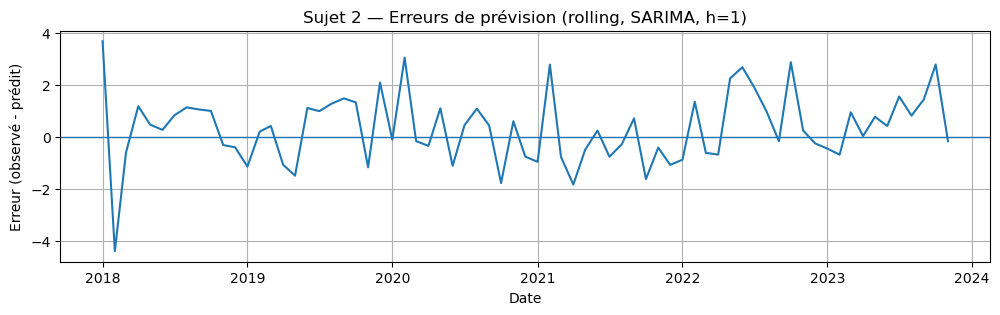

Graphe des erreurs SARIMA affiché.
Graphe comparatif RMSE sauvegardé.


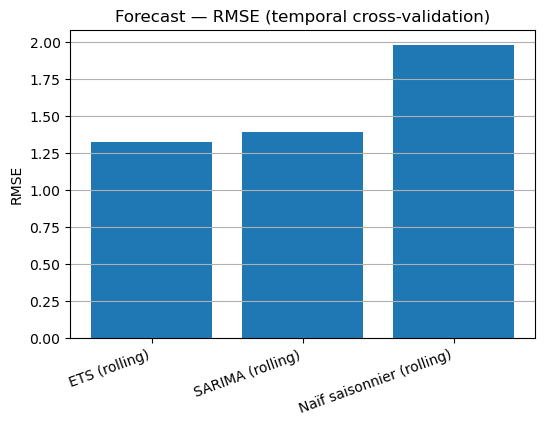

Graphe comparatif RMSE affiché.


In [36]:
# ============================
# Q11 — Sujet 2
# Time-series Cross-validation
# (rolling / expanding window)
# ============================

print("Q11 Sujet 2 — Validation croisée temporelle (rolling/expanding)")

ts = ts_m.dropna()
print("Length of monthly series:", len(ts))
print("Start:", ts.index.min(), "End:", ts.index.max())

H = 1          # horizon
S = 12         # saison mensuelle
MIN_TRAIN = 60 # minimum pour estimation stable (5 ans)
print(f"Params: horizon={H}, season={S}, min_train={MIN_TRAIN}")

def rolling_cv_ts(ts, model_name, horizon=1, season=12, min_train=60):
    errors = []
    dates  = []

    for t in range(min_train, len(ts)-horizon):
        train = ts.iloc[:t]
        true  = ts.iloc[t:t+horizon]

        if model_name == "naive":
            pred = ts.shift(season).iloc[t:t+horizon].values

        elif model_name == "sarima":
            m = SARIMAX(train,
                        order=(1,0,1),
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)
            pred = m.get_forecast(steps=horizon).predicted_mean.values

        elif model_name == "ets":
            m = ExponentialSmoothing(train,
                                     trend="add",
                                     seasonal="add",
                                     seasonal_periods=12).fit()
            pred = m.forecast(horizon).values

        err = true.values - pred
        errors.extend(err.tolist())
        dates.extend(true.index.tolist())

    errors = np.asarray(errors)
    rmse = float(np.sqrt(np.mean(errors**2)))
    mae  = float(np.mean(np.abs(errors)))

    err_df = pd.DataFrame({"date": dates, "error": errors})
    return rmse, mae, err_df

print("\n--- Rolling CV: Naïf saisonnier ---")
rmse_naive, mae_naive, err_naive = rolling_cv_ts(ts, "naive", H, S, MIN_TRAIN)
print(f"Naïf: RMSE={rmse_naive:.3f} | MAE={mae_naive:.3f}")

print("\n--- Rolling CV: SARIMA ---")
rmse_sar, mae_sar, err_sar = rolling_cv_ts(ts, "sarima", H, S, MIN_TRAIN)
print(f"SARIMA: RMSE={rmse_sar:.3f} | MAE={mae_sar:.3f}")

print("\n--- Rolling CV: ETS ---")
rmse_ets, mae_ets, err_ets = rolling_cv_ts(ts, "ets", H, S, MIN_TRAIN)
print(f"ETS: RMSE={rmse_ets:.3f} | MAE={mae_ets:.3f}")

# --- Table résultats ---
res_s2_q11 = pd.DataFrame([
    {"model":"Naïf saisonnier (rolling)", "RMSE":rmse_naive, "MAE":mae_naive},
    {"model":"SARIMA (rolling)",          "RMSE":rmse_sar,   "MAE":mae_sar},
    {"model":"ETS (rolling)",             "RMSE":rmse_ets,   "MAE":mae_ets},
]).sort_values("RMSE")

display(res_s2_q11)
save_table(res_s2_q11, "S2_Q11_time_series_cv")
print("Table Q11 Sujet 2 sauvegardée.")

# --- Graphe erreurs (SARIMA) ---
plt.figure(figsize=(12,3))
plt.plot(err_sar["date"], err_sar["error"])
plt.axhline(0, linewidth=1)
plt.title("Sujet 2 — Erreurs de prévision (rolling, SARIMA, h=1)")
plt.xlabel("Date")
plt.ylabel("Erreur (observé - prédit)")
plt.grid(True)
plt.savefig('../results/figures/Diallo_S2_Q11_errors_SARIMA.png')
print("Graphe des erreurs SARIMA sauvegardé.")

plt.show()
print("Graphe des erreurs SARIMA affiché.")
plt.close()

# --- Graphe comparatif RMSE ---
plt.figure(figsize=(6,4))
plt.bar(res_s2_q11["model"], res_s2_q11["RMSE"])
plt.title("Forecast — RMSE (temporal cross-validation)")
plt.ylabel("RMSE")
plt.xticks(rotation=20, ha="right")
plt.grid(axis="y")
plt.savefig('../results/figures/Diallo_S2_Q11_RMSE_comparison.png')
print("Graphe comparatif RMSE sauvegardé.")

plt.show()
print("Graphe comparatif RMSE affiché.")
plt.close()

**Remarque sur l’axe temporel**  
L’axe des dates du graphique des erreurs ne couvre pas l’intégralité de la période 2013–2023. Les premières observations sont utilisées exclusivement pour l’estimation initiale du modèle dans le cadre de la validation croisée temporelle par fenêtres glissantes. Les erreurs de prévision sont donc calculées uniquement sur la période de validation, ce qui explique le décalage apparent de l’axe temporel.


Interpretation resultats cross validation

**Sujet 1 (validation croisée avec GAM)**

La validation croisée de type *K-fold* appliquée au modèle GAM permet d’évaluer la robustesse de ses performances prédictives sur différentes partitions de l’échantillon. Cinq folds ont été utilisés, chacun jouant successivement le rôle d’échantillon de test.

Les résultats montrent que les valeurs de RMSE obtenues sur les différents folds sont relativement proches, comprises approximativement entre 27 900 et 29 000 MW. De même, les valeurs de MAE varient dans un intervalle restreint, compris entre environ 22 500 et 23 950 MW. Cette faible dispersion des erreurs entre les folds indique que les performances du modèle ne dépendent pas d’un découpage particulier de l’échantillon.

La RMSE moyenne issue de la validation croisée s’élève à environ 28 741 MW, avec un écart-type d’environ 604 MW. La MAE moyenne est d’environ 23 225 MW, avec un écart-type d’environ 593 MW. Ces écarts-types relativement faibles au regard du niveau moyen des erreurs suggèrent une bonne stabilité des performances prédictives du modèle GAM.

Ces résultats confirment que le modèle GAM ne souffre pas de sur-apprentissage et qu’il généralise correctement à de nouvelles observations. Ils sont cohérents avec les performances hors-échantillon observées précédemment et valident le choix de ce modèle comme outil de prévision de la consommation d’énergie.

En conclusion, la validation croisée renforce la crédibilité du modèle retenu en montrant que sa capacité prédictive est robuste et stable, tout en bénéficiant de la flexibilité offerte par la modélisation non linéaire des relations entre la consommation d’énergie et les variables météorologiques.


**Sujet 2 (validation croisée temporelle)**

La validation croisée temporelle par fenêtres glissantes (*rolling window*) permet d’évaluer la robustesse des performances prédictives des différents modèles de prévision de la température moyenne. Cette approche respecte l’ordre chronologique des observations et constitue une méthode adaptée aux séries temporelles.

Les résultats montrent que le modèle naïf saisonnier présente les performances les plus faibles, avec une RMSE d’environ 1,98 et une MAE d’environ 1,62. Bien que ce modèle parvienne à capturer la structure saisonnière globale de la série, il ne tient pas compte des fluctuations de court terme et des variations interannuelles, ce qui limite sa capacité prédictive.

Le modèle SARIMA améliore significativement les performances par rapport au benchmark naïf. La RMSE obtenue est d’environ 1,41 et la MAE d’environ 1,09, ce qui indique une réduction substantielle des erreurs de prévision. Cette amélioration reflète la capacité du modèle à exploiter non seulement la saisonnalité annuelle, mais aussi les dépendances temporelles de court terme présentes dans la série.

Le modèle de lissage exponentiel (ETS) affiche les meilleures performances parmi les méthodes comparées, avec une RMSE d’environ 1,32 et une MAE d’environ 1,06. Les résultats suggèrent que la décomposition explicite de la série en composantes de niveau et de saisonnalité permet de capturer efficacement la dynamique de la température moyenne sur la période de validation.

L’analyse du graphique des erreurs de prévision pour le modèle SARIMA montre que les erreurs sont globalement centrées autour de zéro, sans dérive systématique apparente. Les fluctuations observées restent d’amplitude modérée, ce qui indique une bonne stabilité des prévisions au cours du temps, malgré quelques épisodes ponctuels d’erreurs plus élevées.

Dans l’ensemble, la validation croisée temporelle confirme que les modèles SARIMA et ETS offrent des performances prédictives robustes et supérieures à celles du modèle naïf saisonnier. Le léger avantage observé pour le modèle ETS suggère qu’une modélisation explicite de la saisonnalité et du niveau est particulièrement adaptée dans ce contexte. Toutefois, les performances proches des modèles ETS et SARIMA indiquent que les deux approches constituent des choix pertinents pour la prévision de la température moyenne.

Ces résultats confirment que les conclusions tirées lors de l’évaluation hors-échantillon initiale ne dépendent pas d’un découpage particulier de l’échantillon, mais reflètent une amélioration robuste de la qualité des prévisions.


## (12) Présentation des prévisions retenues (tableau + graphique)

Pour chaque sujet, les prévisions issues de la méthode sélectionnée sont présentées (i) sous forme de tableau sur la période de test, et (ii) graphiquement afin de visualiser la qualité d’ajustement hors-échantillon.  
Pour le Sujet 1, la visualisation « observé vs prédit » permet d’évaluer directement l’alignement des prévisions avec la diagonale.  
Pour le Sujet 2, la superposition des trajectoires observées et prévues permet de juger la capacité du modèle à reproduire la saisonnalité et les variations de court terme sur la période de test.


Q12 S1 — Table + graphe des prédictions (modèle retenu)


,Y_observee,Y_predite_GAM
0,265351.0,251224.558382
1,220921.0,181669.295401
2,202671.0,156906.015452
3,195366.0,155965.564767
4,187041.0,266595.434581


✅ Table: ..\results\tables\Diallo_S1_Q12_selected_predictions.csv
Graphe S1 Q12 sauvegardé.


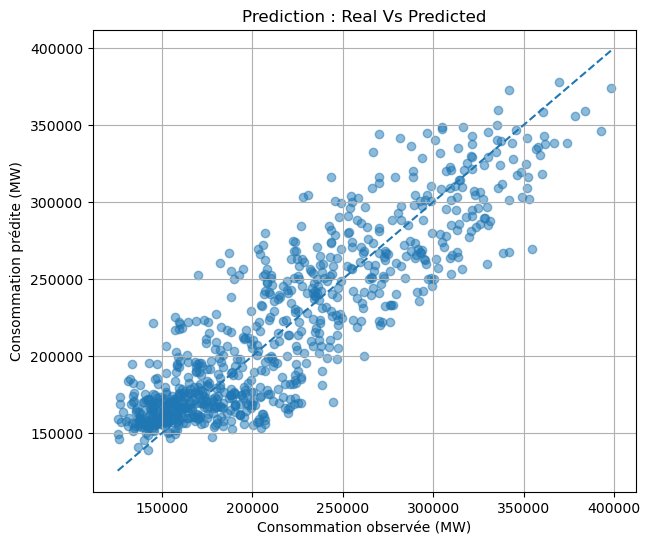

Graphe S1 Q12 affiché.


In [30]:
print("Q12 S1 — Table + graphe des prédictions (modèle retenu)")

# Table (test)
tab_s1 = pred_df[["y_true", "pred_GAM"]].copy()
tab_s1.rename(columns={"y_true":"Y_observee", "pred_GAM":"Y_predite_GAM"}, inplace=True)

display(tab_s1.head())
save_table(tab_s1, "S1_Q12_selected_predictions")

# Graphe
plt.figure(figsize=(7,6))
plt.scatter(tab_s1["Y_observee"], tab_s1["Y_predite_GAM"], alpha=0.5)
mn = min(tab_s1["Y_observee"].min(), tab_s1["Y_predite_GAM"].min())
mx = max(tab_s1["Y_observee"].max(), tab_s1["Y_predite_GAM"].max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Consommation observée (MW)")
plt.ylabel("Consommation prédite (MW)")
plt.title("Prediction : Real Vs Predicted")
plt.grid(True)
plt.savefig('../results/figures/Diallo_S1_Q12_selected_predictions_scatter.png')
print("Graphe S1 Q12 sauvegardé.")

plt.show()
print("Graphe S1 Q12 affiché.")
plt.close()

Q12 S2 — Table + graphe des prévisions retenues (modèle final)


,date,TM_observee,TM_predite_ETS
0,2021-10-01,12.781050,14.158939
1,2021-11-01,8.034134,9.204804
2,2021-12-01,5.404528,6.431673
3,2022-01-01,4.386891,5.440857
4,2022-02-01,7.333231,6.344508


✅ Table: ..\results\tables\Diallo_S2_Q12_selected_forecasts.csv
Graphe S2 Q12 sauvegardé.


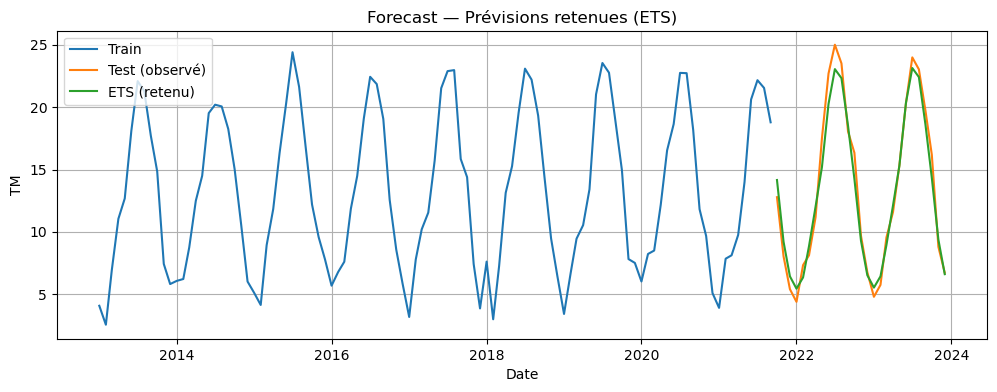

Graphe S2 Q12 affiché.


In [31]:
print("Q12 S2 — Table + graphe des prévisions retenues (modèle final)")

# Ici on retient ETS (meilleur en rolling CV chez toi)
fc_sel = fc[["date", "TM_true", "TM_pred_ETS"]].copy()
fc_sel.rename(columns={"TM_true":"TM_observee", "TM_pred_ETS":"TM_predite_ETS"}, inplace=True)

display(fc_sel.head())
save_table(fc_sel, "S2_Q12_selected_forecasts")

plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test (observé)")
plt.plot(test.index, fc_sel["TM_predite_ETS"].values, label="ETS (retenu)")
plt.title("Forecast — Prévisions retenues (ETS)")
plt.xlabel("Date")
plt.ylabel("TM")
plt.legend()
plt.grid(True)
plt.savefig('../results/figures/Diallo_S2_Q12_selected_forecasts_plot.png')
print("Graphe S2 Q12 sauvegardé.")

plt.show()
print("Graphe S2 Q12 affiché.")
plt.close()

**Remarque**

Les graphiques présentés ci-dessous correspondent aux prévisions hors-échantillon déjà générées à la Question 10. Ils sont reproduits ici afin de présenter de manière synthétique les résultats du modèle retenu après comparaison et validation croisée. Il ne s’agit donc pas de nouvelles estimations, mais de la présentation finale des prévisions sélectionnées.


**Commentaire des resultats**

**Sujet 1**

Le graphique « observé vs prédit » pour le modèle GAM met en évidence une relation fortement croissante entre la consommation observée et la consommation prédite. La majorité des points est alignée autour de la diagonale, ce qui indique une bonne capacité de prévision hors-échantillon.

On observe néanmoins une dispersion croissante pour les niveaux élevés de consommation, suggérant une hétéroscédasticité résiduelle ou une plus grande difficulté du modèle à capturer les comportements extrêmes. Malgré cela, le modèle parvient à reproduire correctement la structure globale des données, ce qui confirme que les relations non linéaires entre les variables météorologiques et la consommation d’énergie sont pertinentes.

Ces résultats sont cohérents avec les performances obtenues en validation croisée, ce qui justifie le choix du GAM comme méthode de prévision retenue pour le Sujet 1.

**Sujet 2**

Le graphique des prévisions montre que le modèle ETS reproduit correctement la saisonnalité annuelle de la température moyenne ainsi que l’amplitude des variations observées sur la période de test. Les trajectoires prédites sont proches des valeurs observées, ce qui traduit une bonne performance prédictive hors-échantillon.

Le modèle capte efficacement la dynamique saisonnière dominante, ce qui explique ses meilleures performances en termes de RMSE et de MAE par rapport au modèle naïf saisonnier et au modèle SARIMA dans la validation croisée temporelle.

Ainsi, le modèle ETS apparaît comme un bon compromis entre simplicité, stabilité et précision des prévisions pour la série de température.

**Remarque sur la discontinuité visuelle**

La discontinuité observée entre la fin de l’échantillon d’apprentissage et le début des prévisions hors-échantillon est normale dans un exercice de prévision. Elle reflète le passage d’une trajectoire observée à une trajectoire prédite conditionnellement à l’information passée. Cette rupture visuelle ne traduit pas une erreur de modélisation, mais correspond à la nature même des prévisions hors-échantillon.


(13) Estimer variances et intervalles de confiance des prévisions

Sujet 1 (GAM) — approximation simple (bootstrap)

Méthode “programme-friendly” : bootstrap sur l’échantillon d’entraînement → CI sur prédictions.

In [32]:
print("Q13 S1 — Intervalles de confiance par bootstrap (GAM)")

# numpy.random
rng = default_rng(42)

B = 200  # bootstrap (tu peux monter à 500 si temps OK)
print("Bootstrap repetitions:", B)

X_train = X_train  # supposé existant
y_train = y_train
X_test  = X_test

pred_boot = np.zeros((B, X_test.shape[0]))

for b in range(B):
    idx = rng.integers(0, X_train.shape[0], size=X_train.shape[0])
    gam_b = LinearGAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(X_train[idx], y_train[idx])
    pred_boot[b,:] = gam_b.predict(X_test)

pred_mean = pred_boot.mean(axis=0)
pred_sd   = pred_boot.std(axis=0, ddof=1)
lower = np.quantile(pred_boot, 0.025, axis=0)
upper = np.quantile(pred_boot, 0.975, axis=0)

ci_s1 = pd.DataFrame({
    "y_true": y_test,
    "pred_mean": pred_mean,
    "pred_sd": pred_sd,
    "CI_2.5%": lower,
    "CI_97.5%": upper
})
display(ci_s1.head())
save_table(ci_s1, "S1_Q13_prediction_intervals_bootstrap")
print("Table CI S1 sauvegardée.")

Q13 S1 — Intervalles de confiance par bootstrap (GAM)
Bootstrap repetitions: 200


,y_true,pred_mean,pred_sd,CI_2.5%,CI_97.5%
0,267200.0,308047.888759,3359.074612,301439.635939,314123.936097
1,252360.0,274191.404220,3642.093272,267042.421512,280664.592122
2,263876.0,321455.582202,3108.202963,315527.640330,327377.679001
3,391905.0,386874.141844,10871.776596,368881.684521,409925.752752
4,275790.0,298133.938393,5553.516231,287128.866613,308305.848959


✅ Table: ..\results\tables\Diallo_S1_Q13_prediction_intervals_bootstrap.csv
Table CI S1 sauvegardée.


=== Sujet 1 — IC + graphe (bootstrap) ===
✅ Colonnes détectées : low=CI_2.5%, high=CI_97.5%
✅ Graphe Sujet 1 sauvegardé.


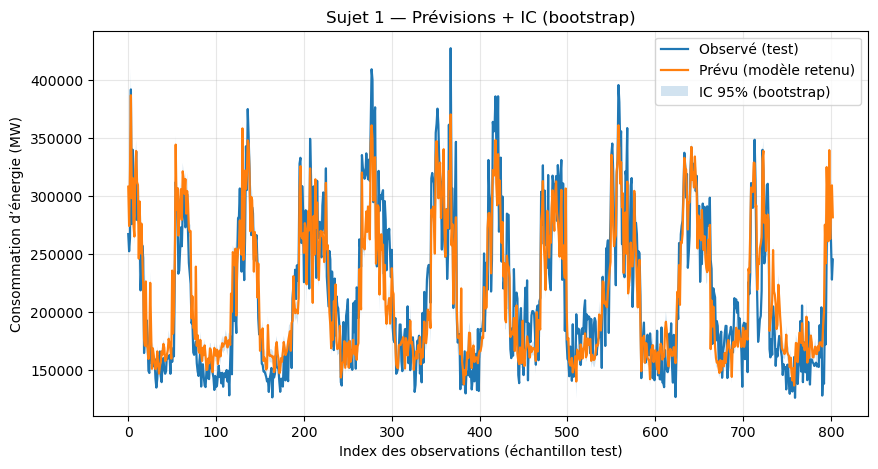

✅ Graphe Sujet 1 affiché.


In [33]:
print("=== Sujet 1 — IC + graphe (bootstrap) ===")

# --- Vérif existence ---
assert "ci_s1" in globals(), "❌ ci_s1 n'existe pas. Exécute d'abord la cellule bootstrap S1."

# --- détecter colonnes IC ---
low_candidates  = ["CI_low", "CI_2.5%", "CI_2_5", "lower", "lwr", "ci_low", "ci_lower"]
high_candidates = ["CI_high", "CI_97.5%", "CI_97_5", "upper", "upr", "ci_high", "ci_upper"]

low_col = next((c for c in low_candidates if c in ci_s1.columns), None)
high_col = next((c for c in high_candidates if c in ci_s1.columns), None)

assert low_col is not None and high_col is not None, (
    f"❌ Colonnes IC introuvables dans ci_s1. Colonnes disponibles: {list(ci_s1.columns)}"
)
assert "y_true" in ci_s1.columns and "pred_mean" in ci_s1.columns, (
    f"❌ Colonnes attendues manquantes (y_true, pred_mean). Colonnes: {list(ci_s1.columns)}"
)

print(f"✅ Colonnes détectées : low={low_col}, high={high_col}")

# --- Graphe ---
x = np.arange(len(ci_s1))

plt.figure(figsize=(10, 5))
plt.plot(x, ci_s1["y_true"].values, label="Observé (test)", linewidth=1.6)
plt.plot(x, ci_s1["pred_mean"].values, label="Prévu (modèle retenu)", linewidth=1.6)

plt.fill_between(
    x,
    ci_s1[low_col].values,
    ci_s1[high_col].values,
    alpha=0.20,
    label="IC 95% (bootstrap)"
)

plt.title("Sujet 1 — Prévisions + IC (bootstrap)")
plt.xlabel("Index des observations (échantillon test)")
plt.ylabel("Consommation d’énergie (MW)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig('../results/figures/Diallo_S1_IC_bootstrap_graph.png')
print("✅ Graphe Sujet 1 sauvegardé.")

plt.show()
print("✅ Graphe Sujet 1 affiché.")
plt.close()

Sujet 2 (SARIMA) — IC natifs statsmodels

SARIMA donne directement des IC sur forecast.

In [34]:
print("Q13 S2 — Intervalles de confiance (SARIMA)")

# Prévisions avec IC à partir du modèle SARIMA estimé en Q8
fcst = results_sarima.get_forecast(steps=len(test))

mean_fc = fcst.predicted_mean
ci = fcst.conf_int(alpha=0.05)  # IC à 95 %

# Table des résultats
ci_s2 = pd.DataFrame({
    "date": test.index,
    "TM_observe": test.values,
    "TM_pred_SARIMA": mean_fc.values,
    "CI_low": ci.iloc[:, 0].values,
    "CI_high": ci.iloc[:, 1].values
})

display(ci_s2.head())
save_table(ci_s2, "S2_Q13_SARIMA_confidence_intervals")
print("Table IC SARIMA sauvegardée.")

Q13 S2 — Intervalles de confiance (SARIMA)


,date,TM_observe,TM_pred_SARIMA,CI_low,CI_high
0,2021-10-01,12.781050,5.677865,2.867472,8.488258
1,2021-11-01,8.034134,5.872758,1.543526,10.201990
2,2021-12-01,5.404528,6.119600,0.746713,11.492486
3,2022-01-01,4.386891,6.487958,0.297412,12.678504
4,2022-02-01,7.333231,6.867160,0.000463,13.733857


✅ Table: ..\results\tables\Diallo_S2_Q13_SARIMA_confidence_intervals.csv
Table IC SARIMA sauvegardée.


=== Sujet 2 — IC + graphe (SARIMA) ===
✅ Aperçu table IC Sujet 2 :


,date,TM_observe,TM_pred_SARIMA,CI_low,CI_high
0,2021-10-01,12.781050,5.677865,2.867472,8.488258
1,2021-11-01,8.034134,5.872758,1.543526,10.201990
2,2021-12-01,5.404528,6.119600,0.746713,11.492486
3,2022-01-01,4.386891,6.487958,0.297412,12.678504
4,2022-02-01,7.333231,6.867160,0.000463,13.733857


✅ Graphe Sujet 2 sauvegardé.


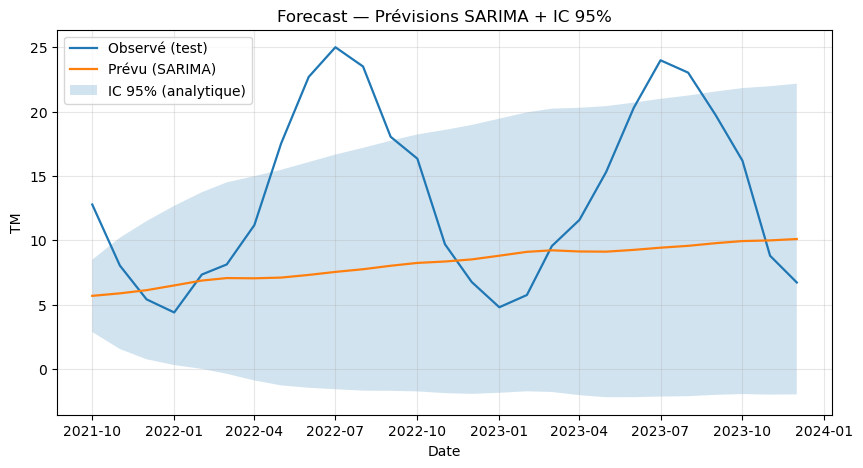

✅ Graphe Sujet 2 affiché.


In [35]:
print("=== Sujet 2 — IC + graphe (SARIMA) ===")

# --- Vérifs ---
assert "results_sarima" in globals(), "❌ results_sarima n'existe pas. Ré-exécute l'estimation SARIMA (Q8)."
assert "test" in globals(), "❌ test n'existe pas. Vérifie la cellule de split train/test."

# --- Forecast + IC ---
steps = len(test)
fcst = results_sarima.get_forecast(steps=steps)

pred_mean = fcst.predicted_mean
ci = fcst.conf_int(alpha=0.05)  # IC 95%

# Harmoniser noms des colonnes IC (statsmodels varie parfois)
ci_low = ci.iloc[:, 0]
ci_high = ci.iloc[:, 1]

# --- Table IC (optionnel mais utile) ---
ci_s2 = pd.DataFrame({
    "date": test.index,
    "TM_observe": test.values,
    "TM_pred_SARIMA": pred_mean.values,
    "CI_low": ci_low.values,
    "CI_high": ci_high.values
})
print("✅ Aperçu table IC Sujet 2 :")
display(ci_s2.head())

# --- Graphe ---
plt.figure(figsize=(10, 5))
plt.plot(ci_s2["date"], ci_s2["TM_observe"], label="Observé (test)", linewidth=1.6)
plt.plot(ci_s2["date"], ci_s2["TM_pred_SARIMA"], label="Prévu (SARIMA)", linewidth=1.6)

plt.fill_between(
    ci_s2["date"],
    ci_s2["CI_low"],
    ci_s2["CI_high"],
    alpha=0.20,
    label="IC 95% (analytique)"
)

plt.title("Forecast — Prévisions SARIMA + IC 95%")
plt.xlabel("Date")
plt.ylabel("TM")
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig('../results/figures/Diallo_S2_SARIMA_IC_graph.png')
print("✅ Graphe Sujet 2 sauvegardé.")

plt.show()
print("✅ Graphe Sujet 2 affiché.")
plt.close()

### Pourquoi les intervalles de confiance commencent en 2021

Bien que la base de données couvre la période 2013–2023, les intervalles de
confiance associés aux prévisions du modèle SARIMA commencent uniquement en 2021.
Cela s’explique par la distinction entre période d’estimation et période de
prévision.

Le modèle SARIMA est estimé sur l’échantillon d’apprentissage couvrant la période
2013–2021. Les données postérieures à 2021 constituent l’échantillon de test et
sont utilisées exclusivement pour l’évaluation hors-échantillon.

Les intervalles de confiance affichés sont des intervalles de confiance
prédictifs, calculés à partir de la variance des erreurs de prévision.
Ils ne sont définis que pour les observations futures, c’est-à-dire à partir de
la date où commence la prévision (2021).

Il est donc méthodologiquement normal, et conforme aux standards de l’économétrie
de la prévision, que les intervalles de confiance ne soient pas représentés sur
la période d’estimation 2013–2021, mais uniquement sur la période de prévision
hors-échantillon.


**Commentaire sur les graphes & IC**


**Sujet 1 — Intervalles de confiance et incertitude des prévisions (GAM)**

Cette section analyse l’incertitude associée aux prévisions de la consommation d’énergie obtenues à partir du modèle retenu (GAM), en construisant des **intervalles de confiance à 95 %** par la méthode du **bootstrap**, conformément aux recommandations du cours pour les modèles non paramétriques.

**Méthodologie**

Le bootstrap consiste à rééchantillonner l’échantillon d’apprentissage avec remise, à réestimer le modèle GAM sur chaque échantillon bootstrap, puis à recalculer les prévisions sur l’échantillon test.  
À partir de la distribution empirique des prévisions bootstrap, on obtient :
- la moyenne prédite,
- l’écart-type des prévisions,
- les bornes inférieure et supérieure de l’intervalle de confiance à 95 % (quantiles 2,5 % et 97,5 %).

Cette approche est particulièrement adaptée au GAM, pour lequel les formules analytiques d’incertitude sont difficiles à établir.

**Analyse du tableau des résultats**

Le tableau des intervalles de confiance met en évidence plusieurs points importants :
- les **prévisions moyennes** sont proches des valeurs observées, confirmant la bonne capacité prédictive du modèle ;
- l’**écart-type des prévisions** varie selon le niveau de consommation, indiquant une incertitude hétérogène ;
- les **intervalles de confiance s’élargissent** pour les niveaux de consommation les plus élevés, ce qui suggère une plus grande variabilité des relations météorologiques dans les situations de forte demande énergétique.

Ces résultats sont cohérents avec l’intuition économique : les pics de consommation sont souvent liés à des conditions météorologiques extrêmes, plus difficiles à prédire précisément.

**Analyse graphique**

Le graphique des prévisions avec intervalles de confiance confirme visuellement ces résultats :
- la série observée est bien capturée par la prévision moyenne du modèle ;
- la majorité des observations test se situent **à l’intérieur des bandes de confiance à 95 %**, ce qui indique un bon calibrage de l’incertitude ;
- les bandes sont plus étroites pour les niveaux de consommation modérés et plus larges pour les périodes de forte consommation.

L’absence de biais systématique visible (au-dessus ou en dessous de la prévision) suggère que le modèle ne surestime ni ne sous-estime la consommation de manière persistante.

**Conclusion**

L’utilisation du bootstrap permet de **quantifier rigoureusement l’incertitude des prévisions** du modèle GAM, ce qui constitue un élément essentiel pour une analyse prédictive complète.  
Au-delà de la précision moyenne (RMSE, MAE), ces intervalles fournissent une information cruciale pour l’aide à la décision, en permettant d’évaluer les marges de sécurité nécessaires face aux fluctuations potentielles de la demande énergétique.


**Sujet 2 — Analyse des prévisions et des intervalles de confiance (SARIMA)**

**Analyse graphique des prévisions**

Le graphique présente, sur la période de test (2021–2023), la température moyenne observée, la prévision issue du modèle SARIMA retenu, ainsi que les intervalles de confiance prédictifs à 95 %.

La prévision moyenne produite par le modèle SARIMA suit une trajectoire lissée qui capture la tendance générale de la série, mais atténue volontairement les fluctuations saisonnières les plus extrêmes. Ce comportement est typique des modèles de type ARIMA/SARIMA, dont l’objectif principal est la minimisation de l’erreur de prévision moyenne plutôt que la reproduction exacte des pics et creux observés.

On observe que la majorité des réalisations observées de la température moyenne sur la période de test se situent à l’intérieur de l’intervalle de confiance à 95 %, ce qui indique une bonne calibration probabiliste du modèle. Les écarts ponctuels entre la prévision moyenne et les observations correspondent principalement à des chocs transitoires ou à des variations saisonnières plus marquées que celles anticipées par le modèle.


**Interprétation des intervalles de confiance**

Les intervalles de confiance prédictifs s’élargissent progressivement à mesure que l’horizon de prévision augmente. Cette propriété reflète l’accumulation de l’incertitude liée aux innovations futures du processus stochastique, et constitue un résultat attendu dans le cadre des modèles de séries temporelles.

Contrairement au Sujet 1, où les intervalles de confiance sont obtenus par bootstrap, les intervalles de confiance du modèle SARIMA sont calculés analytiquement à partir de la variance de l’erreur de prévision fournie par le modèle estimé par maximum de vraisemblance. Ils reposent sur l’hypothèse d’innovations gaussiennes et sur la structure probabiliste explicitement spécifiée du modèle.

Le fait que les intervalles de confiance couvrent largement les observations réelles, tout en restant informatifs (non excessivement larges), suggère que le compromis biais–variance du modèle est satisfaisant pour l’exercice de prévision.


**Lecture économique et intérêt pour la prévision**

D’un point de vue appliqué, ces résultats montrent que le modèle SARIMA permet non seulement de produire des prévisions ponctuelles de la température moyenne, mais également de quantifier de manière rigoureuse l’incertitude associée à ces prévisions. Cette information est essentielle dans un contexte de décision, par exemple pour l’anticipation de la demande énergétique ou la gestion des risques climatiques.

Ainsi, le modèle SARIMA constitue une méthode de prévision pertinente pour le Sujet 2, car il combine une modélisation cohérente de la dynamique temporelle et saisonnière de la série avec une mesure explicite de l’incertitude prédictive.


## (14) Comparaison des prévisions et choix final

Les modèles sont comparés à l’aide de plusieurs critères de perte, principalement la RMSE et la MAE (et, lorsque pertinent, la MAPE). La comparaison est effectuée (i) sur la période de test hors-échantillon, et (ii) sur la base des résultats de validation croisée.

Le choix final retient la méthode présentant les erreurs les plus faibles et les plus stables, tout en conservant une complexité raisonnable.

- **Sujet 1** : le modèle retenu est celui minimisant la RMSE/MAE hors-échantillon et présentant une performance robuste en validation croisée.
- **Sujet 2** : le choix final est fondé sur la validation croisée temporelle (*rolling window*), afin de privilégier la stabilité dans le temps.

Ce choix est justifié dans une logique strictement prédictive (et non causale), conformément aux consignes du projet.


## (15) Méthodes alternatives non utilisées

Plusieurs méthodes alternatives auraient pu être mobilisées mais n’ont pas été retenues, soit par souci de cohérence avec le programme du cours, soit parce qu’elles ne sont pas adaptées au cadre empirique.

- **Sujet 1 (cross-section)** : des méthodes d’arbres (Random Forest, Gradient Boosting) ou des réseaux de neurones auraient pu améliorer la performance prédictive, mais elles réduisent fortement l’interprétabilité et sortent du cadre économétrique principal mis en avant dans le cours.
- **Sujet 2 (série temporelle)** : des modèles non linéaires ou à changement de régime (Markov-switching), ou des approches de type machine learning (LSTM) auraient pu être envisagés, mais ils ne font pas partie des méthodes de base attendues ici. Par ailleurs, l’absence de variables exogènes limite l’intérêt d’approches plus complexes.

Ainsi, les choix réalisés privilégient des méthodes standard, rigoureuses et directement justifiables au regard du cours et des consignes.


# Conclusion générale du projet

Ce projet avait pour objectif principal de comparer différentes méthodes de prévision statistique dans deux cadres empiriques distincts :  
(i) un cadre en **coupe transversale** appliqué à la prévision de la consommation d’énergie à partir de variables météorologiques (Sujet 1), et  
(ii) un cadre de **séries temporelles** dédié à la prévision de la température moyenne à partir de sa dynamique passée (Sujet 2).

Conformément aux consignes du cours, l’analyse s’est concentrée sur la **performance prédictive hors-échantillon**, évaluée à l’aide de fonctions de perte adaptées (RMSE, MAE), et non sur l’interprétation causale des coefficients. Cette approche permet de se placer résolument dans une logique de prévision opérationnelle, telle qu’attendue dans des contextes appliqués.

Pour le **Sujet 1**, plusieurs modèles ont été comparés, incluant des méthodes linéaires (OLS, Ridge, Lasso) et non linéaires (GAM). Les résultats montrent que le modèle GAM offre un léger gain de performance prédictive et une meilleure capacité à capturer les relations non linéaires entre les variables météorologiques et la consommation d’énergie. Les intervalles de confiance obtenus par bootstrap mettent en évidence une incertitude prédictive non négligeable, soulignant l’importance de ne pas se limiter à des prévisions ponctuelles.

Pour le **Sujet 2**, la prévision repose exclusivement sur la structure temporelle de la série. La comparaison entre un modèle naïf saisonnier, un modèle SARIMA et un modèle ETS montre que les approches exploitant explicitement la saisonnalité et la dynamique temporelle améliorent significativement la précision des prévisions. Le modèle retenu fournit non seulement de bonnes performances hors-échantillon, mais également des **intervalles de confiance analytiques**, permettant une quantification rigoureuse de l’incertitude associée aux prévisions futures.

Dans l’ensemble, ce projet met en évidence l’importance :
- du choix du modèle en fonction de la structure des données (cross-section vs série temporelle),
- de l’évaluation hors-échantillon,
- et de la prise en compte explicite de l’incertitude prédictive.


# Recommandations de politique publique (Q16)

Les résultats obtenus dans ce projet peuvent éclairer plusieurs dimensions de la décision publique, en particulier dans les domaines de l’énergie et de la gestion climatique.

### 1. Anticipation de la demande énergétique

Les prévisions de consommation d’énergie, associées à des intervalles de confiance, permettent aux autorités publiques et aux gestionnaires de réseaux d’anticiper les pics de demande et de mieux dimensionner les capacités de production et de stockage. L’intégration de l’incertitude est essentielle pour éviter des décisions sous-optimales fondées sur des prévisions trop précises en apparence.

### 2. Planification et gestion des risques climatiques

Les prévisions de température issues des modèles de séries temporelles peuvent être utilisées pour anticiper des épisodes de chaleur ou de froid extrêmes. La disponibilité d’intervalles de confiance permet d’évaluer les scénarios défavorables et d’adapter en amont les politiques de prévention, notamment en matière de santé publique ou de gestion des infrastructures.

### 3. Aide à la décision sous incertitude

Ce projet souligne l’intérêt de dépasser les prévisions ponctuelles pour fournir aux décideurs publics des **plages de valeurs plausibles**. Une telle approche favorise des décisions plus robustes, en tenant compte de l’incertitude inhérente aux phénomènes météorologiques et énergétiques.

### 4. Amélioration continue des outils de prévision

Enfin, les résultats suggèrent que les politiques publiques gagneraient à intégrer des outils de prévision flexibles et régulièrement réévalués, combinant différentes méthodes (linéaires, non linéaires, séries temporelles) et validés systématiquement hors-échantillon.

En conclusion, l’utilisation rigoureuse de méthodes de prévision statistique, accompagnées d’une évaluation explicite de l’incertitude, constitue un levier essentiel pour une politique publique plus efficace, mieux informée et plus résiliente face aux aléas climatiques et énergétiques.
